# Imports

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn import metrics
from sklearn import dummy
from sklearn import svm
from sklearn import ensemble
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

from lime.lime_tabular import LimeTabularExplainer

import time
from contextlib import contextmanager
import gc
import warnings
import pprint
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from IPython.display import clear_output

sns.set()

# Configuration

In [2]:
DEBUG = True
DF_MAIN = None
TARGET_COLUMN = 'TARGET'
TEST_SIZE = 0.3
SKIP_TRAINS = False
SAMPLE_ROWS = 10000
RANDOM_STATE= 190276

ROOT_INPUT = './data/original/'


# Fonctions

## Utilitaires

In [45]:
# Time tracking
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - éxécuté en {:.0f}s".format(title, time.time() - t0))

# Read and Sample CSV
def read(name):
    path = ROOT_INPUT + name
    if DEBUG: print(f"Read file {path}")
    df = pd.read_csv(ROOT_INPUT + name)
    if DEBUG: print(f'{name} shape: {df.shape}')
    return df

# Affichage des infos du dataset
def infos(df: pd.DataFrame, head = False):
    memory_gb = np.round(df.memory_usage(deep=True).sum()/(1024**3),2)
    nb_lignes = df.shape[0]
    nb_columns = df.shape[1]
    print(f'A ce stade ce dataset contient {nb_lignes} lignes et {nb_columns} colonnes. (conso mémoire {memory_gb}Gb)')
    if head:
        return df.head()
    
# Graphe des taux de remplissage
def remplissage(df: pd.DataFrame, treshold = 101, ascending = False):
    df_na = pd.DataFrame(((1- df.isna().mean()) * 100).round(0)).rename(columns={0: 'mean'})
    df_na = df_na[df_na['mean'] < treshold]
    ax = sns.barplot(data=df_na, x='mean', y=df_na.index, palette='rainbow', order=df_na.sort_values(by='mean', ascending=ascending).index)
    ax.bar_label(ax.containers[0], fmt='%.0f%%', padding=-35, c="white")
    plt.title(f'Taux de remplissage inférieur à {treshold} : {df_na.size} colonnes')
    plt.show()
    
    del df_na, ax
    gc.collect()

def Xy(df):
    X = df.drop([TARGET_COLUMN], axis=1)
    y = df[TARGET_COLUMN]
    return X, y
    
def split(df):
    df_train, df_test = model_selection.train_test_split(df, test_size=TEST_SIZE, random_state= RANDOM_STATE)
    return df_train, df_test

def scale(df):
    scaler = preprocessing.StandardScaler()
    X,y = Xy(df)
    columns = X.columns
    X_scaled = scaler.fit_transform(X)
    
    df_scaled = pd.DataFrame(X_scaled, columns=columns)
    df_scaled[TARGET_COLUMN] = y
    
    del scaler, X, y, columns, X_scaled
    gc.collect()
    
    return df_scaled

def plot_repartition(df_train, df_test):
    value_counts_train = df_train_resample[TARGET_COLUMN].value_counts().values
    value_counts_test = df_test[TARGET_COLUMN].value_counts().values

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
                                    
    ax1.pie(value_counts_train, labels=[f'Repaid ({value_counts_train[0]})', f'Not repaid ({value_counts_train[1]})'], autopct='%.0f%%')
    ax1.set_title('Répartition cible train')

    ax2.pie(value_counts_test, labels=[f'Repaid ({value_counts_test[0]})', f'Not repaid ({value_counts_test[1]})'], autopct='%.0f%%')
    ax2.set_title('Répartition cible test')

    plt.show()
    
    del value_counts_train, value_counts_test, fig, ax1, ax2
    gc.collect()
    
def one_hot_encode(df):
    if DEBUG: print(f"shape before encode: {df.shape}")    
    
    previous_columns = df.columns.to_list()
    df = pd.get_dummies(df)
    after_columns = df.columns.to_list()
    cols = [col for index, col in enumerate(after_columns) if col not in previous_columns]
        
    if DEBUG: print(f"shape after encode: {df.shape}")
    
    del previous_columns, after_columns
    gc.collect()
    
    return df, cols

def rename_columns(df, prefix):
    df.columns = pd.Index([prefix + e[0] + "_" + e[1].upper() for e in df.columns.tolist()])
    if DEBUG: 
        print("Renaming columns:")
        pprint.pprint(df.columns.to_list())
    return df

def feature_importance(df_test, estimator, ax, importances_limit=30, logy=False):
    X_test, y_test = Xy(df_test)
    result = permutation_importance(
        estimator, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1
    )
    
    estimator_importances = pd.DataFrame({'mean': result.importances_mean, 'error': result.importances_std}, index=X_test.columns.to_list())
    estimator_importances['absolute'] = np.absolute(estimator_importances['mean'])
    estimator_importances_top = estimator_importances.nlargest(importances_limit, 'absolute').sort_values(by='mean', ascending=False)
    
    estimator_importances_top['mean'].plot.bar(yerr=estimator_importances_top['error'], ax=ax, logy=logy)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    
    del X_test, y_test, result, estimator_importances
    gc.collect()
    
    return estimator_importances_top

def learning_curve(model, df_train, ax):
    X_train, y_train = Xy(df_train)
    N, train_score, val_score = model_selection.learning_curve(model,
                                                               X_train,
                                                               y_train,
                                                               cv=4,
                                                               scoring='roc_auc', 
                                                               random_state=RANDOM_STATE,
                                                               n_jobs=-1,
                                                               train_sizes=np.linspace(0.1, 1, 10))


    val_score_means = val_score.mean(axis=1)
    arg_max_val_score = np.nanargmax(val_score_means)
    max_val_score = val_score_means[arg_max_val_score]
    
    ax.plot(N, train_score.mean(axis=1), label='train score')
    ax.plot(N, val_score_means, label='validation score')
    ax.scatter(x = N[arg_max_val_score], color = 'b', y= max_val_score, marker='*', s=150)
    ax.legend()
    
    print(f'Max score {max_val_score} obtained with {N[arg_max_val_score]} lines')

    del X_train, y_train, N, train_score, val_score, val_score_means, arg_max_val_score, max_val_score
    gc.collect()
    
def calc_custom_score(row, true_positive_point=1, true_negative_point=1, false_positive_point=-10, false_negative_point=-1):
    if row.predict == 0 and row.target == 0:
        # Vrai positif
        return true_positive_point
    elif row.predict == 1 and row.target == 1:
        # Vrai negatif
        return true_negative_point
    elif row.predict == 0 and row.target == 1:
        # Faux positif
        return false_positive_point
    elif row.predict == 1 and row.target == 0:
        # Faux negatif
        return false_negative_point

def custom_scoring(estimator, X, y):    
    decid = pd.DataFrame(estimator.predict(X), columns=['predict'])
    decid['target'] = list(y)
    decid['score'] = decid.apply(calc_custom_score, axis=1)
    return decid['score'].mean()

def explain_prediction(estimator, df_test, index, num_features=5):
    X_test, y_test = Xy(df_test)
    
    # Categoricals
    cat_feat_ix = [i for i,c in enumerate(X_test.columns) if pd.api.types.is_bool_dtype(X_test[c])]
    cat_names = [c for i,c in enumerate(X_test.columns) if pd.api.types.is_bool_dtype(X_test[c])]
    
    # Int to float to prevent "OverflowError: Python int too large to convert to C long"
    X_test = X_test.astype('float')

    lime_explainer = LimeTabularExplainer(X_test.to_numpy(),
                                          feature_names=list(X_test.columns),
                                          class_names=['Remboursable', 'Non Remboursable'],
                                          categorical_features=cat_feat_ix ,
                                          categorical_names=cat_names,
                                          mode="classification"
                                          )

    exp = lime_explainer.explain_instance(X_test.to_numpy()[index], estimator.predict_proba, num_features=num_features)

    exp.show_in_notebook(show_table=True, show_all=False)

## Process Sub DataFrames

In [4]:
def process_bureau_balance():
    
    if DEBUG: print("========= BUREAU BALANCE ============")
        
    # Read DATA
    df = read('bureau_balance.csv')
    
    # One Hot encode categories
    df, cols = one_hot_encode(df)
    
    # Aggregation
    agg = {}
    for col in cols:
        agg[col] = ['mean']
        
    agg = {**agg, 
           'MONTHS_BALANCE': ['min', 'max', 'mean']
          }

    if DEBUG: 
        print("Aggregate:")
        pprint.pprint(agg)
        
    df = df.groupby('SK_ID_BUREAU').agg(agg)
    
    # Columns renaming
    df = rename_columns(df, 'BUREAU_BALANCE_')
    
    del cols, agg
    gc.collect()
    
    return df

def process_bureau():
    
    if DEBUG: print("========= BUREAU ============")
        
    # Read DATA
    df = read('bureau.csv')
    
    # Create new columns
    df['CREDIT_DURATION'] = df['DAYS_CREDIT_ENDDATE'] - df['DAYS_CREDIT']
    
    # One Hot encode categories
    df, cols = one_hot_encode(df)
    
    # Join with bureau balance
    bureau_balance = process_bureau_balance()
    df = df.join(bureau_balance, how='left', on='SK_ID_BUREAU')
    df = df.drop(columns=['SK_ID_BUREAU'], axis=1)
    
    # Aggregation
    agg = {}
    for col in cols:
        agg[col] = ['mean']
        
    for col in bureau_balance.columns:
        agg[col] = ['mean']
        
    agg = {**agg, 
           'DAYS_CREDIT': ['min', 'max', 'mean'],
           'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
           'DAYS_CREDIT_UPDATE': ['mean'],
           'CREDIT_DAY_OVERDUE': ['max', 'mean'],
           'AMT_CREDIT_MAX_OVERDUE': ['mean'],
           'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
           'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
           'AMT_CREDIT_SUM_OVERDUE': ['mean'],
           'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
           'AMT_ANNUITY': ['max', 'mean'],
           'CNT_CREDIT_PROLONG': ['sum'],
           'CREDIT_DURATION': ['min', 'max', 'mean']
          }
    if DEBUG:  
        print("Aggregate:")
        pprint.pprint(agg)
        
    df = df.groupby('SK_ID_CURR').agg(agg)
    
    # Columns renaming
    df = rename_columns(df, 'BUREAU_')
    
    del cols, bureau_balance, agg
    gc.collect()
    
    return df

def process_POS_CASH_balance():
    
    if DEBUG: print("========= POS CASH BALANCE ============")
        
    # Read DATA
    df = read('POS_CASH_balance.csv')
    
    # Create LATE columns
    df['LATE_PAYMENT'] = df['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    
    # Remove SK_ID_PREV
    df.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # One Hot encode categories
    df, cols = one_hot_encode(df)
    
    # Aggregation
    agg = {}
    for col in cols:
        agg[col] = ['mean']
        
    agg = {**agg, 
           'MONTHS_BALANCE': ['min', 'max', 'mean'],
           'SK_DPD': ['min', 'max', 'mean'],
           'SK_DPD_DEF': ['min', 'max', 'mean'],
           'LATE_PAYMENT': ['mean']
          }
    if DEBUG:
        print("Aggregate:")
        pprint.pprint(agg)
        
    df = df.groupby('SK_ID_CURR').agg(agg)
    
    # Columns renaming
    df = rename_columns(df, 'POS_CASH_BALANCE_')
    
    del cols, agg
    gc.collect()
    
    return df

def process_installments_payments():
    
    if DEBUG: print("========= INSTALLMENTS PAYMENTS ============")
        
    # Read DATA
    df = read('installments_payments.csv')
    
    # Create LATE columns
    df['LATE_PAYMENT'] = (df['DAYS_ENTRY_PAYMENT'] - df['DAYS_INSTALMENT']).apply(lambda x: 1 if x > 0 else 0)
    
    # Create PAYMENT columns
    df['PAYMENT'] = (df['AMT_PAYMENT'] - df['AMT_INSTALMENT']).apply(lambda x: 1 if x > 0 else 0)
    
    # Remove SK_ID_PREV
    df.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # One Hot encode categories
    df, cols = one_hot_encode(df)
    
    # Aggregation
    agg = {}
    for col in cols:
        agg[col] = ['mean']
        
    agg = {**agg, 
           'NUM_INSTALMENT_VERSION': ['max'],
           'NUM_INSTALMENT_NUMBER': ['min', 'max', 'mean'],
           'LATE_PAYMENT': ['mean'],
           'PAYMENT': ['mean']
          }
    if DEBUG:
        print("Aggregate:")
        pprint.pprint(agg)
        
    df = df.groupby('SK_ID_CURR').agg(agg)
    
    # Columns renaming
    df = rename_columns(df, 'INSTALLMENTS_PAYMENTS_')
    
    del cols, agg
    gc.collect()
    
    return df

def process_credit_card_balance():
    
    if DEBUG: print("========= CREDIT CARD BALANCE ============")
        
    # Read DATA
    df = read('credit_card_balance.csv')
    
    # Late payment
    df['LATE_PAYMENT'] = df['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    
    # Remove SK_ID_PREV
    df.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # One Hot encode categories
    df, cols = one_hot_encode(df)
    
    # Aggregation
    agg = {}
    for col in cols:
        agg[col] = ['mean']
        
    agg = {**agg, 
           'MONTHS_BALANCE': ['min', 'max', 'mean'],
           'AMT_BALANCE': ['max'],
           'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max'],
           'AMT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
           'AMT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
           'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
           'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
           'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
           'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
           'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
           'CNT_DRAWINGS_CURRENT': ['mean'],
           'CNT_DRAWINGS_POS_CURRENT': ['mean'],
           'SK_DPD': ['min', 'max', 'mean'],
           'SK_DPD_DEF': ['min', 'max', 'mean'],
           'LATE_PAYMENT': ['mean']
          }
    if DEBUG:
        print("Aggregate:")
        pprint.pprint(agg)
        
    df = df.groupby('SK_ID_CURR').agg(agg)
    
    # Columns renaming
    df = rename_columns(df, 'CREDIT_CARD_BALANCE_')
    
    del cols, agg
    gc.collect()
    
    return df

def process_previous_application():
    
    if DEBUG: print("========= PREVIOUS APPLICATION ============")
        
    # Read DATA
    df = read('previous_application.csv')
    
    # Remove SK_ID_PREV
    df.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # One Hot encode categories
    df, cols = one_hot_encode(df)
    
    # Aggregation
    agg = {}
    for col in cols:
        agg[col] = ['mean']
        
    agg = {**agg, 
           'AMT_ANNUITY': ['min', 'max', 'mean'],
           'AMT_APPLICATION': ['min', 'max', 'mean'],
           'AMT_CREDIT': ['min', 'max', 'mean'],
           'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
           'AMT_GOODS_PRICE': ['min', 'max', 'mean']
          }
    if DEBUG:
        print("Aggregate:")
        pprint.pprint(agg)
        
    df = df.groupby('SK_ID_CURR').agg(agg)
    
    # Columns renaming
    df = rename_columns(df, 'PREVIOUS_APPLICATION_')
    
    del cols, agg
    gc.collect()
    
    return df

## Feature Engineering

In [5]:
def add_polynomial_features(df, columns, degree=3):
    df_poly = DF_MAIN.loc[:, columns]
    df_poly = df_poly.fillna(df_poly.mean())
    from sklearn.preprocessing import PolynomialFeatures
    poly_transformer = PolynomialFeatures(degree = degree)
    np_poly = poly_transformer.fit_transform(df_poly)
    poly_columns = poly_transformer.get_feature_names_out(input_features=columns)[len(columns)+1:]
    df_poly = pd.DataFrame(np_poly[:, len(columns)+1:], columns=poly_columns)
    df_poly['SK_ID_CURR'] = DF_MAIN['SK_ID_CURR']
    df = df.merge(df_poly, on='SK_ID_CURR', how ='left')
    
    del df_poly, poly_transformer, np_poly
    gc.collect()
    
    return df

## Estimator

In [62]:
def exec_estimator(estimator,
                   ax1 = None, 
                   ax2 = None,
                   ax_learning_curve = None,
                   estimator_params = {},
                   importances_limit = 30,
                   smote = None,
                   smote_params = {},     
                   randomize = False,
                   randomize_iter = 10,
                   column_treshold = None,
                   column_names = None,
                   na = 'mean',
                   scaler = None,
                   cv = 3, 
                   display_importance  = False, 
                   importance_logy = False,
                   polynomial_columns = None,
                   polynomial_columns_randomize=None,
                   polynomial_degree = 3, 
                   sample = None, 
                   print_score_only = False,
                   scoring = 'roc_auc'):

    if SKIP_TRAINS:
        return
    
    name=estimator.__class__.__name__
    
    print("======================================")
    print(f"Fit {name}")
    
    steps = []
    df = DF_MAIN.copy()
    
    if polynomial_columns_randomize:
        polynomial_columns = np.random.choice(df.columns.drop('TARGET').to_list(), polynomial_columns_randomize).tolist()
        if not print_score_only: print(f"Polynomials columns choosed:")
        if not print_score_only: pprint.pprint(polynomial_columns)
        
    if polynomial_columns:
        df = add_polynomial_features(df, polynomial_columns, polynomial_degree)
        if not print_score_only: print(f"shape after polynomials features addings: {df.shape}")
        
    if column_names:
        df = df.loc[:, column_names + ['TARGET']]
        importances_limit = df.shape[1]
        if not print_score_only: print(f"shape after column select: {df.shape}")
    
    if column_treshold:
        df = df.loc[:, df.isna().mean() < column_treshold/100]
        if not print_score_only: print(f"shape after column treshold: {df.shape}")
    
    if (na == 'mean'):
        df = df.fillna(df.mean())
    elif (na == 'median'):
        df = df.fillna(df.median())
    elif type(na) == int:
        df = df.fillna(value=na)
    
    if not print_score_only: print(f"shape after process na by {na}: {df.shape}")

    
    if DEBUG: 
        df = df.sample(n=SAMPLE_ROWS, random_state= RANDOM_STATE)
        if not print_score_only: print(f"shape after sampling {SAMPLE_ROWS} rows: {df.shape}")
    elif sample:
        df = df.sample(n=sample, random_state= RANDOM_STATE)
        if not print_score_only: print(f"shape after sampling {sample} rows: {df.shape}")
        
    df_train, df_test = split(df)    
    X_train, y_train = Xy(df_train)
    X_test, y_test = Xy(df_test)
    
    if scaler:
        steps.append(("scaler", scaler))
        
    if smote:
        steps.append(("smote", smote))
    
    steps.append(("estimator", estimator))
        
    pipe = Pipeline(steps=steps)
    
   
    
    # Parameters of pipelines can be set using '__' separated parameter names:
    param_grid = {**smote_params, **estimator_params}
    best_estimator = None
    search = None
    feature_importance_result = None
    
    with timer("Training"):
        if len(param_grid) > 0:
            if randomize:
                search = RandomizedSearchCV(pipe, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1, return_train_score=True, n_iter=randomize_iter)
                search.fit(X_train, y_train)
            else:
                search = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1, return_train_score=True)
                search.fit(X_train, y_train)

            if not print_score_only: print("Meilleurs parametres:")
            if not print_score_only: pprint.pprint(search.best_estimator_.get_params())
            print("Meilleurs score: %0.3f" % search.best_score_)
            best_estimator = search.best_estimator_
        else: 
            pipe.fit(X_train, y_train)
            
            if scoring == 'roc_auc':
                score = metrics.roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
            else:
                score = scoring(pipe, X_test, y_test) 
                                
            if polynomial_columns_randomize:
                print("Score: %0.3f" % score)
                return score, polynomial_columns
            else:
                if not print_score_only: print("Parametres:")
                if not print_score_only: pprint.pprint(pipe.get_params())
                print("Score: %0.3f" % score)
                best_estimator = pipe
    
    with timer("Score displaying"):
        if scoring == 'roc_auc':
            metrics.RocCurveDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax1, alpha=0.8, name=name)
        else:
            ax1.bar(name, score)
            ax1.set_title('Score personalisé')
            ax1.xaxis.set_tick_params(labelsize=10)
            
    if display_importance:
        with timer("Feature importance displaying"):
            feature_importance_result = feature_importance(df, best_estimator, ax2, importances_limit, importance_logy)

    if ax_learning_curve:
        with timer("Learning curve displaying"):
            learning_curve(best_estimator, df, ax_learning_curve)
    
    
    del name, steps, df, df_train, X_train, X_test, y_train, y_test, pipe, param_grid, search
    gc.collect()
    
    return feature_importance_result, best_estimator, df_test

# Process DataFrame Train

In [7]:
def process_train():
    # Read DATA
    df = read('application_train.csv')
    
    # One Hot encode categories
    df, cols = one_hot_encode(df)
    
    # Join with bureau
    with timer("Process bureau"):
        bureau = process_bureau()
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    
    # Join with POS CASH Balance
    with timer("Process POS_CASH_balance"):
        POS_CASH_balance = process_POS_CASH_balance()
        df = df.join(POS_CASH_balance, how='left', on='SK_ID_CURR')
        del POS_CASH_balance
        gc.collect()
    
    # Join with installments payments
    with timer("Process installments_payments"):
        installments_payments = process_installments_payments()
        df = df.join(installments_payments, how='left', on='SK_ID_CURR')
        del installments_payments
        gc.collect()
    
    # Join with credit card balance
    with timer("Process credit_card_balance"):
        credit_card_balance = process_credit_card_balance()
        df = df.join(credit_card_balance, how='left', on='SK_ID_CURR')
        del credit_card_balance
        gc.collect()
    
    # Join with previous application
    with timer("Process previous_application"):
        previous_application = process_previous_application()
        df = df.join(previous_application, how='left', on='SK_ID_CURR')
        del previous_application
        gc.collect()
    
    df.loc[df['DAYS_EMPLOYED'] > 0, ['DAYS_EMPLOYED']] = np.NAN
    
    
    df_return = df.copy()
    del df
    gc.collect()
    
    return df_return

with timer("Process MAIN"):
    DF_MAIN= process_train()

Read file ./data/original/application_train.csv
application_train.csv shape: (307511, 122)
shape before encode: (307511, 122)
shape after encode: (307511, 246)
========= BUREAU ============
Read file ./data/original/bureau.csv
bureau.csv shape: (1716428, 17)
shape before encode: (1716428, 18)
shape after encode: (1716428, 38)
========= BUREAU BALANCE ============
Read file ./data/original/bureau_balance.csv
bureau_balance.csv shape: (27299925, 3)
shape before encode: (27299925, 3)
shape after encode: (27299925, 10)
Aggregate:
{'MONTHS_BALANCE': ['min', 'max', 'mean'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean']}
Renaming columns:
['BUREAU_BALANCE_STATUS_0_MEAN',
 'BUREAU_BALANCE_STATUS_1_MEAN',
 'BUREAU_BALANCE_STATUS_2_MEAN',
 'BUREAU_BALANCE_STATUS_3_MEAN',
 'BUREAU_BALANCE_STATUS_4_MEAN',
 'BUREAU_BALANCE_STATUS_5_MEAN',
 'BUREAU_BALANCE_STATUS_C

# Exploration

In [8]:
infos(DF_MAIN, True)

A ce stade ce dataset contient 307511 lignes et 527 colonnes. (conso mémoire 0.93Gb)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   
1      100003       0             0          270000.0   1293502.5   
2      100004       0             0           67500.0    135000.0   
3      100006       0             0          135000.0    312682.5   
4      100007       0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  ...  PREVIOUS_APPLICATION_AMT_APPLICATION_MEAN  \
0         -637.0  ...                                  179055.00   
1        -1188.0  ...                                  435436.50   
2         -225.0  ...                                   24282.00   
3        -3039.0  ...                                  272203.26   
4        -3038.0  ...                                  150530.25   

   PREVIOUS_APPLICATION_AMT_CREDIT_MIN  PREVIOUS_APPLICATION_AMT_CREDIT_MAX  \
0                             179055.0                             179055.0   
1                              68053.5                            1035882.0   
2                              20106.0                              20106.0   
3                                  0.0                             906615.0   
4                              14616.0                             284400.0   

   PREVIOUS_APPLICATION_AMT_CREDIT_MEAN  \
0                             179055.00   
1                             484191.00   
2                              20106.00   
3                             291695.50   
4                             166638.75   

   PREVIOUS_APPLICATION_AMT_DOWN_PAYMENT_MIN  \
0                                       0.00   
1                                       0.00   
2                                    4860.00   
3                                    2693.34   
4                                    3105.00   

   PREVIOUS_APPLICATION_AMT_DOWN_PAYMENT_MAX  \
0                                        0.0   
1                                     6885.0   
2                                     4860.0   
3                                    66987.0   
4                                     3676.5   

   PREVIOUS_APPLICATION_AMT_DOWN_PAYMENT_MEAN  \
0                                        0.00   
1                                     3442.50   
2                                     4860.00   
3                                    34840.17   
4                                     3390.75   

   PREVIOUS_APPLICATION_AMT_GOODS_PRICE_MIN  \
0                                 179055.00   
1                                  68809.50   
2                                  24282.00   
3                                  26912.34   
4                                  17176.50   

   PREVIOUS_APPLICATION_AMT_GOODS_PRICE_MAX  \
0                                  179055.0   
1                                  900000.0   
2                                   24282.0   
3                                  688500.0   
4                                  247500.0   

   PREVIOUS_APPLICATION_AMT_GOODS_PRICE_MEAN  
0                                  179055.00  
1                                  435436.50  
2                                   24282.00  
3                                  408304.89  
4                                  150530.25  

[5 rows x 527 columns]

In [9]:
DF_MAIN.dtypes.value_counts()

float64    347
bool       140
int64       40
Name: count, dtype: int64

## Cible

In [10]:
DF_MAIN[TARGET_COLUMN].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

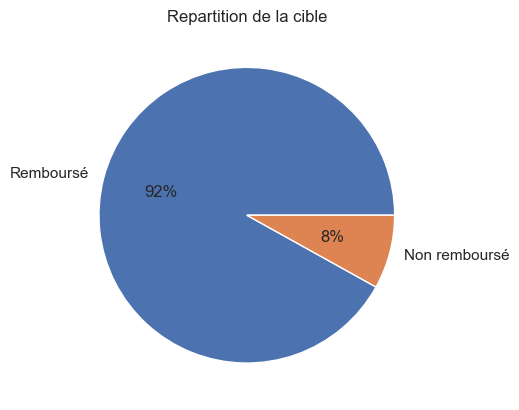

In [11]:
plt.pie(DF_MAIN[TARGET_COLUMN].value_counts().values, labels=['Remboursé', 'Non remboursé'], autopct='%.0f%%')
plt.title('Repartition de la cible')
plt.show()

<u>La cible est binaire:</u>

    0 = Le crédit a été remboursé<br>
    1 = Le crédit n'a pas été remboursé

    En conséquence il s'agit d'un problème de classification binaire.<br>
    Nous pouvons envisager 2 metriques pour choisir le meilleur algorithme:

    1. L'accuracy (taux de bonnes prédictions)
    2. L'AUROC (L'aire sous la courbe roc qui permet de maximiser les Vrais positifs et minimiser les faux positifs, et de choisir le seuil optimal)

<u>La cible est déséquilibrée</u>

    L'utilisation d'une métrique de type Accuracy est déconseillée (https://lrouviere.github.io/TUTO_ML/dondes.htmlhttps://lrouviere.github.io/TUTO_ML/dondes.html) car même un bon score ne permet de connaitre la répartition des vrais/faux positifs.<br>
    Exemple: Je pourrai obtenir 90% d'accuracy avec de mauvaises prédictions qui soient toutes des faux positifs (auquel cas je vais accorder 10% de mes crédits à de mauvais clients).<br>
    
### Conclusion    

    1. La métrique choisie est donc l'AUROC.
    2. On donnera un poids aux classes si possible lors de l'apprentissage (scale_pos_weight par exemple dans les params XGBoost)

## Valeurs manquantes

<Axes: >

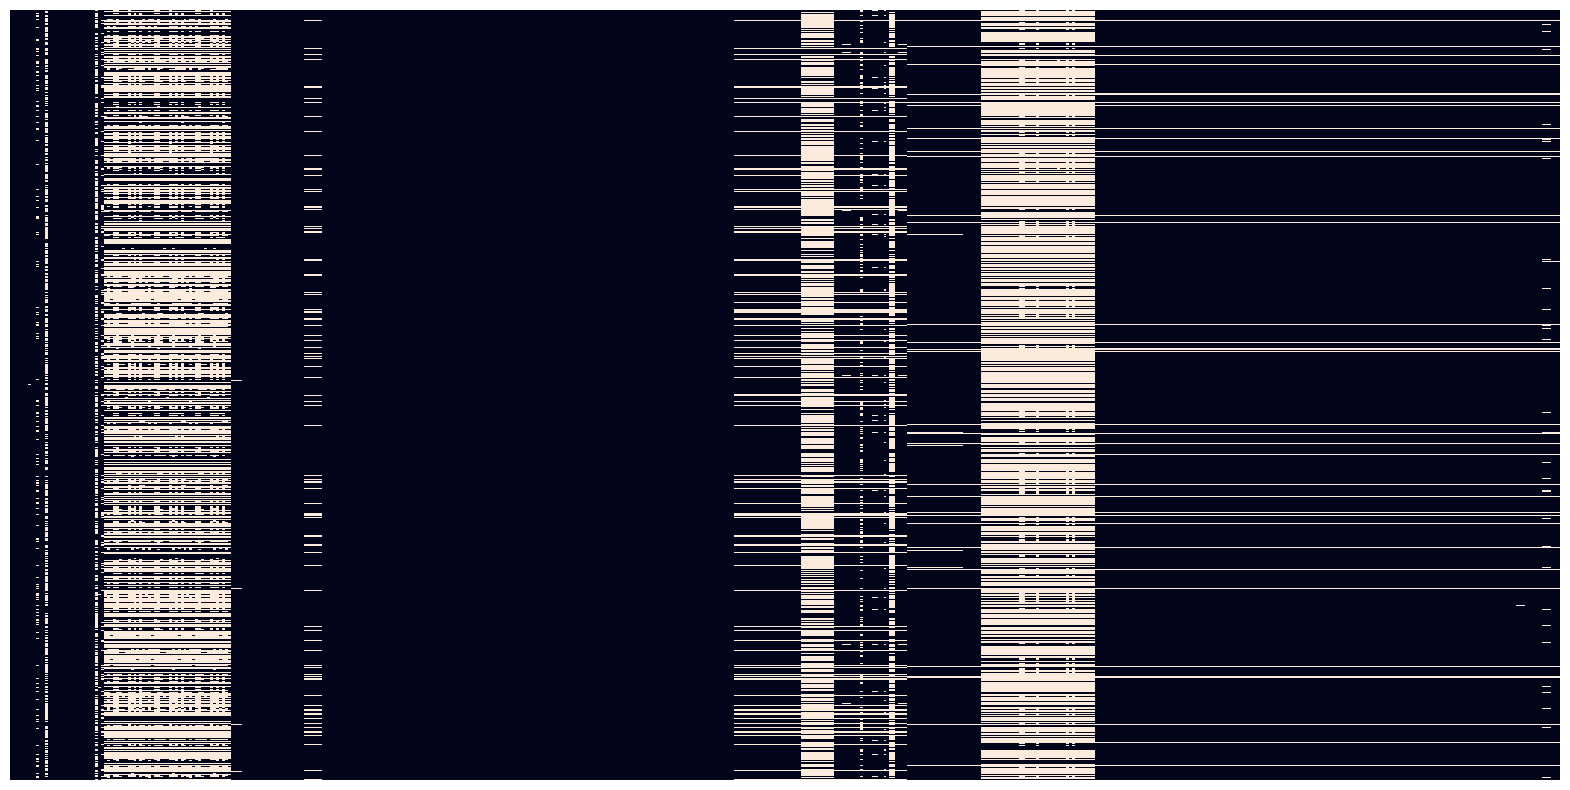

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(DF_MAIN.isna(), cbar=False, xticklabels=False, yticklabels=False)

Noir = Plein | Blanc = Vide

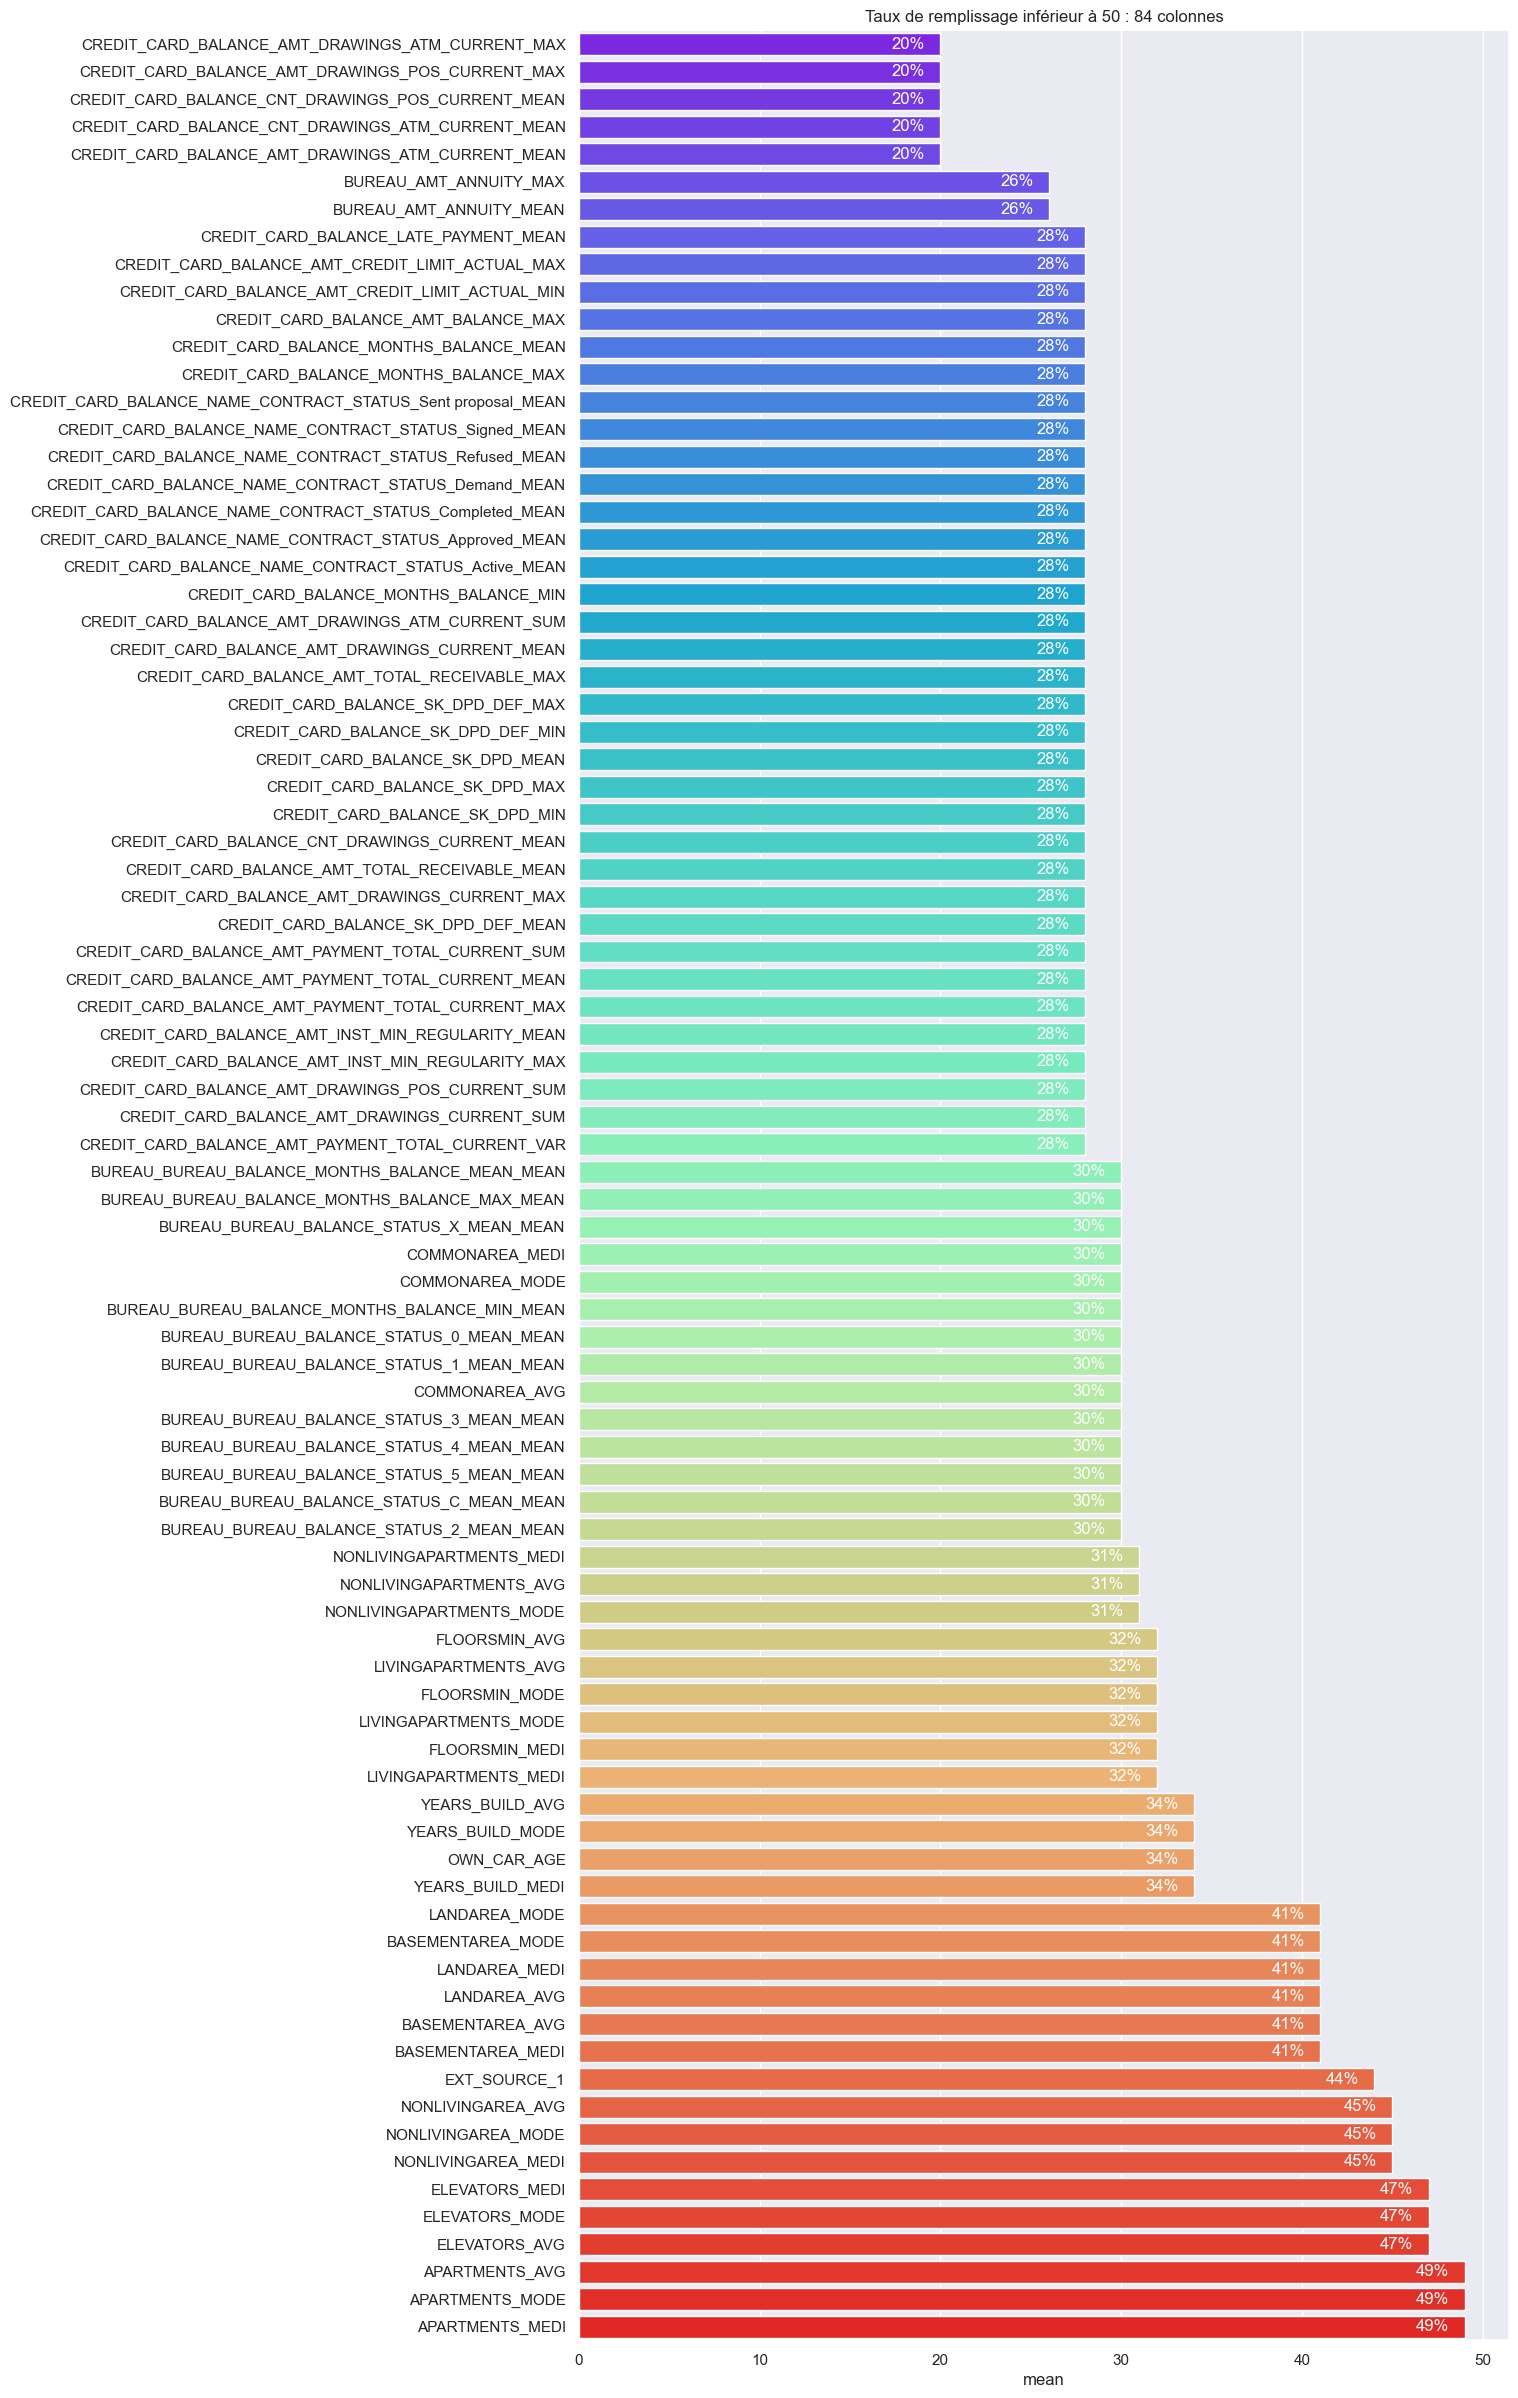

In [13]:
plt.figure(figsize=(12,30))
remplissage(DF_MAIN, 50, True)

On testera plusieurs solutions sur les modèles d'apprentissage

- Laisser le model gerer les valeurs manquantes si ce paramètrage est possible
- Imputer des colonnes (moyenne, mediane)
- Supprimer des colonnes trop vides

## Correlations / Cible

Pour une simplicité d'analyse, creation de 3 colonnes temporaires AGE et DUREE_EMPLOI et DUREE_TELEPHONE basées sur DAYS_BIRTH et DAYS_EMPLOYED et DAYS_LAST_PHONE_CHANGE

In [14]:
df_corr = DF_MAIN.copy()
df_corr['AGE'] = DF_MAIN['DAYS_BIRTH'] / -365
df_corr['DUREE_EMPLOI'] = DF_MAIN['DAYS_EMPLOYED'] / -365 
df_corr['DUREE_TELEPHONE'] = DF_MAIN['DAYS_LAST_PHONE_CHANGE'] / -365 

In [15]:
df_corr['AGE'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE, dtype: float64

In [16]:
df_corr['DUREE_EMPLOI'].describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DUREE_EMPLOI, dtype: float64

In [17]:
df_corr['DUREE_TELEPHONE'].describe()

count    307510.000000
mean          2.637969
std           2.265229
min          -0.000000
25%           0.750685
50%           2.073973
75%           4.301370
max          11.758904
Name: DUREE_TELEPHONE, dtype: float64

In [18]:
corr = df_corr.corr(numeric_only=True)[TARGET_COLUMN].dropna().sort_values()

In [19]:
corr.head(10)

EXT_SOURCE_3                                              -0.178919
EXT_SOURCE_2                                              -0.160472
EXT_SOURCE_1                                              -0.155317
BUREAU_CREDIT_ACTIVE_Closed_MEAN                          -0.079369
AGE                                                       -0.078239
DUREE_EMPLOI                                              -0.074958
PREVIOUS_APPLICATION_CODE_REJECT_REASON_XAP_MEAN          -0.073930
PREVIOUS_APPLICATION_NAME_CONTRACT_STATUS_Approved_MEAN   -0.063521
NAME_EDUCATION_TYPE_Higher education                      -0.056593
BUREAU_BUREAU_BALANCE_STATUS_C_MEAN_MEAN                  -0.055936
Name: TARGET, dtype: float64

In [20]:
corr.tail(10)

BUREAU_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_MEAN            0.076424
BUREAU_CREDIT_ACTIVE_Active_MEAN                          0.077356
PREVIOUS_APPLICATION_NAME_CONTRACT_STATUS_Refused_MEAN    0.077671
DAYS_BIRTH                                                0.078239
CREDIT_CARD_BALANCE_CNT_DRAWINGS_CURRENT_MEAN             0.082520
CREDIT_CARD_BALANCE_AMT_TOTAL_RECEIVABLE_MEAN             0.086490
BUREAU_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN             0.089038
BUREAU_DAYS_CREDIT_MEAN                                   0.089729
CREDIT_CARD_BALANCE_CNT_DRAWINGS_ATM_CURRENT_MEAN         0.107692
TARGET                                                    1.000000
Name: TARGET, dtype: float64

In [21]:
del corr

## Analyse de l'age / remboursement

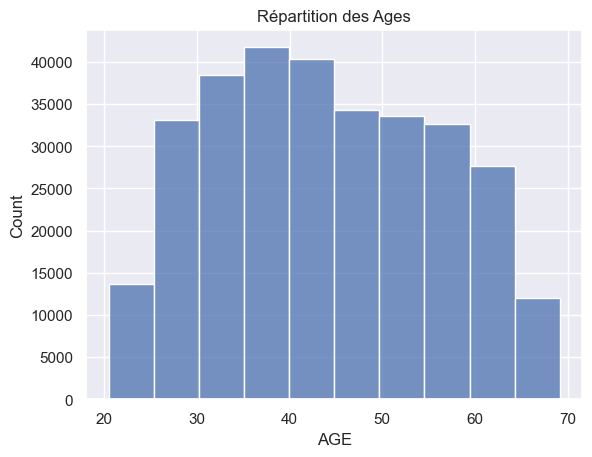

In [22]:
ax = sns.histplot(data=df_corr, x='AGE', bins=10)
ax.set(title='Répartition des Ages')
plt.show()
del ax

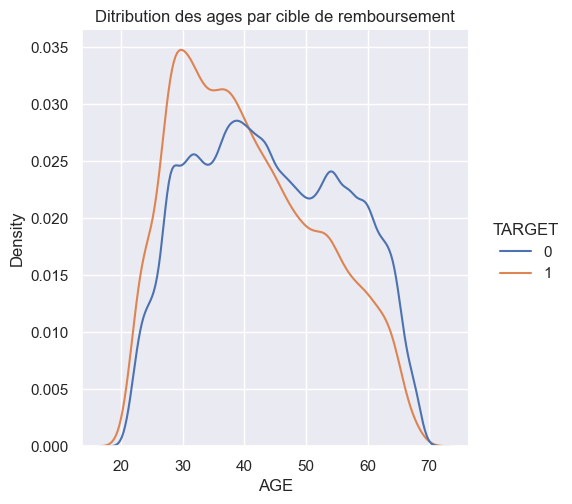

In [23]:
ax = sns.displot(data=df_corr, x="AGE", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title='Ditribution des ages par cible de remboursement')
plt.show()
del ax

Les plus jeunes ont une tendance à moins bien rembourser que les plus agés

## Analyse Durée de l'emploi / remboursement

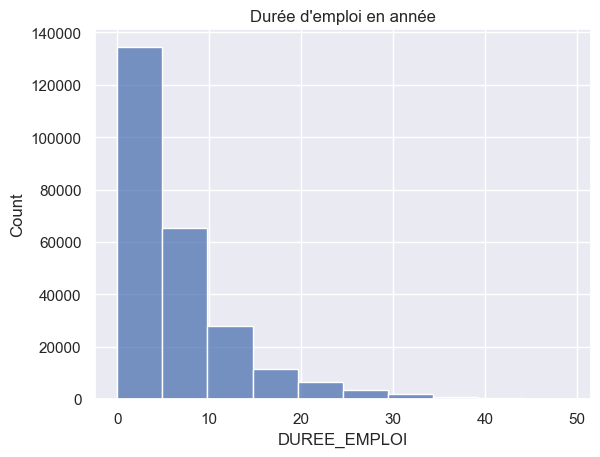

In [24]:
ax = sns.histplot(data=df_corr, x='DUREE_EMPLOI', bins=10)
ax.set(title="Durée d'emploi en année")
plt.show()
del ax

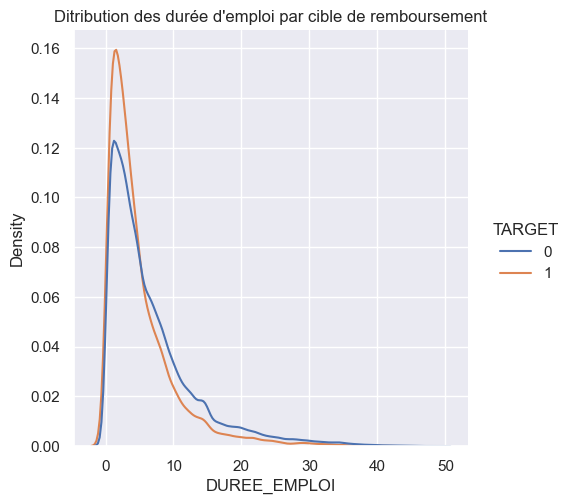

In [25]:
ax = sns.displot(data=df_corr, x="DUREE_EMPLOI", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution des durée d'emploi par cible de remboursement")
plt.show()
del ax

Ceux dont la durée d'emploi est la plus faible ont tendance à moins bien rembourser

## Analyse des scores externes / Remboursement

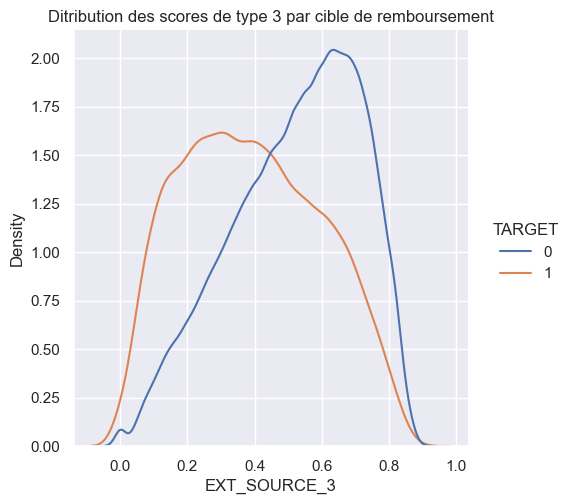

In [26]:
ax = sns.displot(data=df_corr, x="EXT_SOURCE_3", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution des scores de type 3 par cible de remboursement")
plt.show()
del ax

Ceux dont le score 3 est le plus faible ont tendance à moins bien rembourser

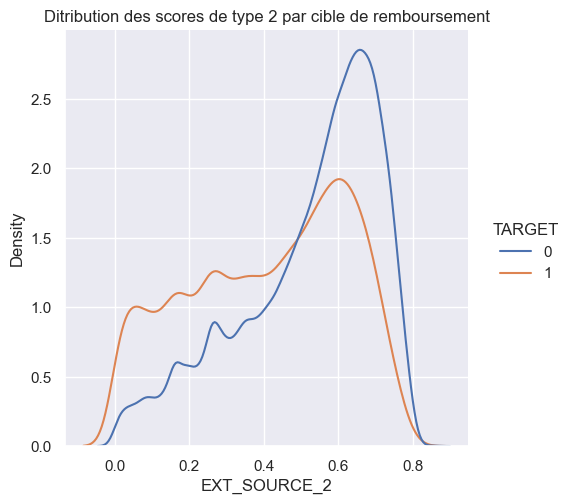

In [27]:
ax = sns.displot(data=df_corr, x="EXT_SOURCE_2", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution des scores de type 2 par cible de remboursement")
plt.show()
del ax

Ceux dont le score 2 est le plus faible ont tendance à moins bien rembourser

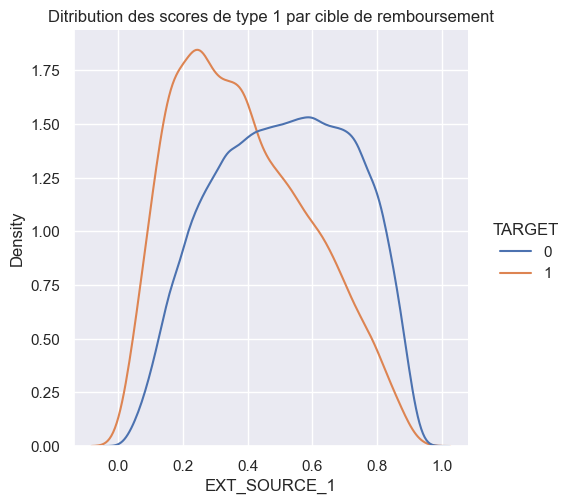

In [28]:
ax = sns.displot(data=df_corr, x="EXT_SOURCE_1", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution des scores de type 1 par cible de remboursement")
plt.show()
del ax

Ceux dont le score 1 est plus faible ont tendance à moins bien rembourser

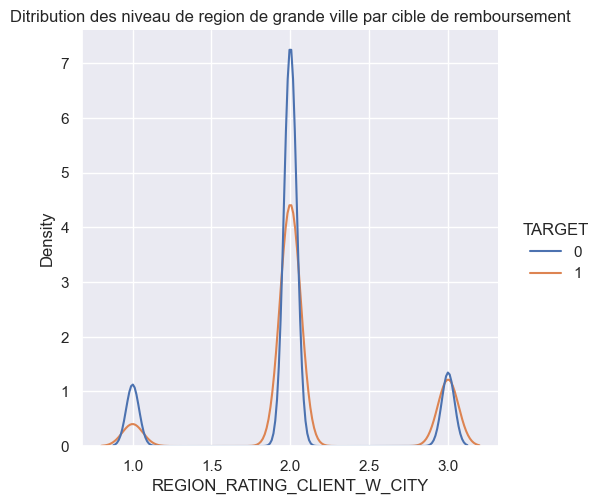

In [29]:
ax = sns.displot(data=df_corr, x="REGION_RATING_CLIENT_W_CITY", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution des niveau de region de grande ville par cible de remboursement")
plt.show()
del ax

Ceux dont le niveau est clasé 1 ou 2 remboursent mieux

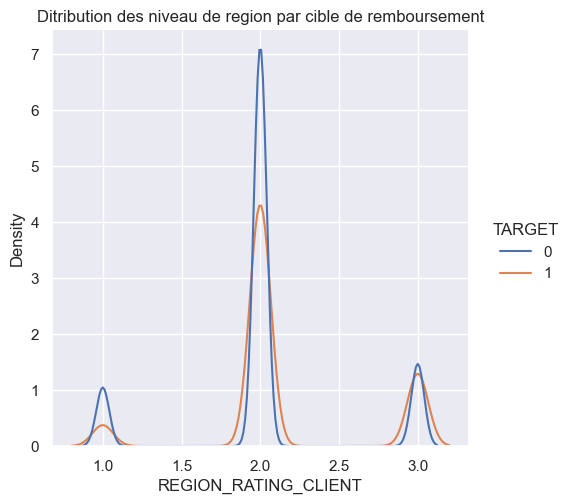

In [30]:
ax = sns.displot(data=df_corr, x="REGION_RATING_CLIENT", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution des niveau de region par cible de remboursement")
plt.show()
del ax

Ceux dont le niveau est classé 1 ou 2 remboursent mieux

## Analyse durée de possession du numero de téléphone / remboursement

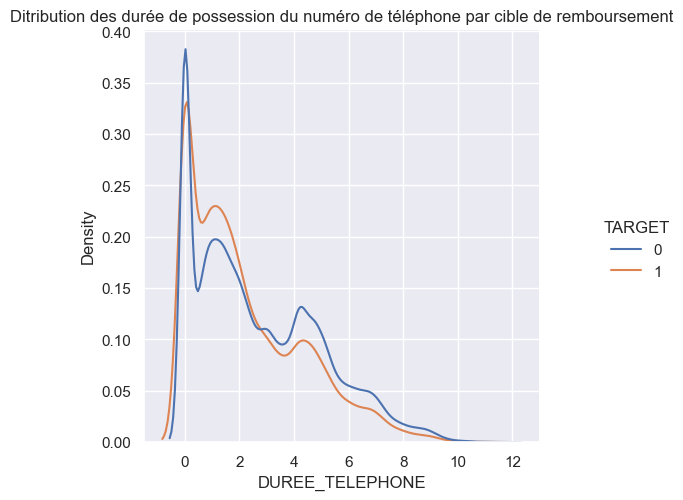

In [31]:
ax = sns.displot(data=df_corr, x="DUREE_TELEPHONE", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution des durée de possession du numéro de téléphone par cible de remboursement")
plt.show()
del ax

Ceux dont la durée de possession du numéro de téléphone est faible ont tendance à moins bien rembourser

## Analyse Nombre d'enfants / remboursement

In [32]:
df_corr['CNT_CHILDREN'].describe()

count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

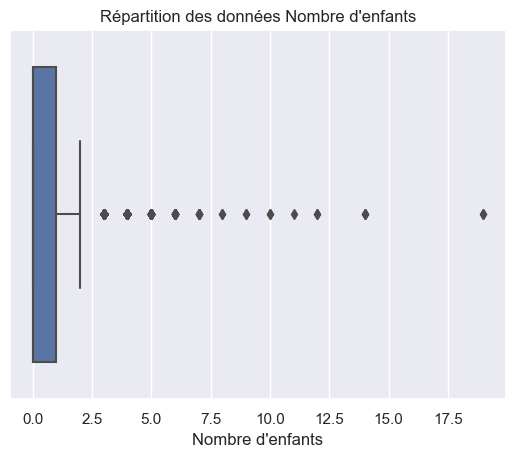

In [33]:
sns.boxplot(data=df_corr, x='CNT_CHILDREN')
plt.xlabel("Nombre d'enfants")
plt.title("Répartition des données Nombre d'enfants")
plt.show()

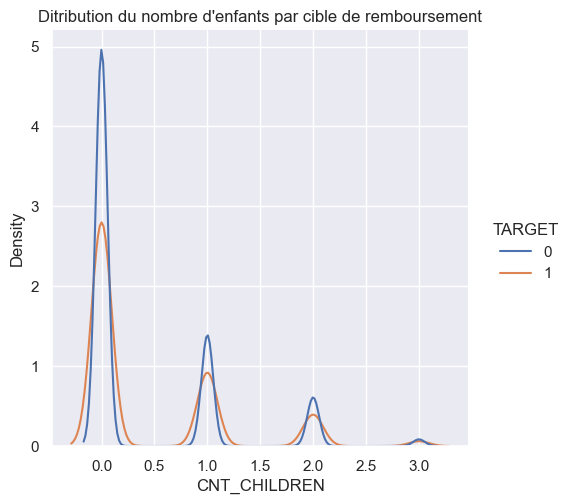

In [34]:
ax = sns.displot(data=df_corr.loc[df_corr['CNT_CHILDREN'] < 4], x="CNT_CHILDREN", kind="kde", hue=TARGET_COLUMN, common_norm=False)
ax.set(title="Ditribution du nombre d'enfants par cible de remboursement")
plt.show()
del ax

On constate que plus le nombre d'enfants augmente, plus le defaut de paiement est probable

In [35]:
del df_corr
gc.collect()

20128

# Entrainements Phase 1

Recherche du modèle le plus performant parmis 
- SVC
- BaggingClassifier
- RandomForestClassifier
- GradientBoostingClassifier
- AdaBoostClassifier

Fit DummyClassifier
shape after process na by mean: (307511, 527)
shape after sampling 10000 rows: (10000, 527)
Parametres:
{'estimator': DummyClassifier(strategy='most_frequent'),
 'estimator__constant': None,
 'estimator__random_state': None,
 'estimator__strategy': 'most_frequent',
 'memory': None,
 'steps': [('estimator', DummyClassifier(strategy='most_frequent'))],
 'verbose': False}
Score: 0.500
Training - éxécuté en 0s
ROC Curve displaying - éxécuté en 0s
DummyClassifier - éxécuté en 4s
Fit SVC
shape after process na by mean: (307511, 527)
shape after sampling 10000 rows: (10000, 527)
Parametres:
{'estimator': SVC(probability=True, random_state=190276),
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': 

0

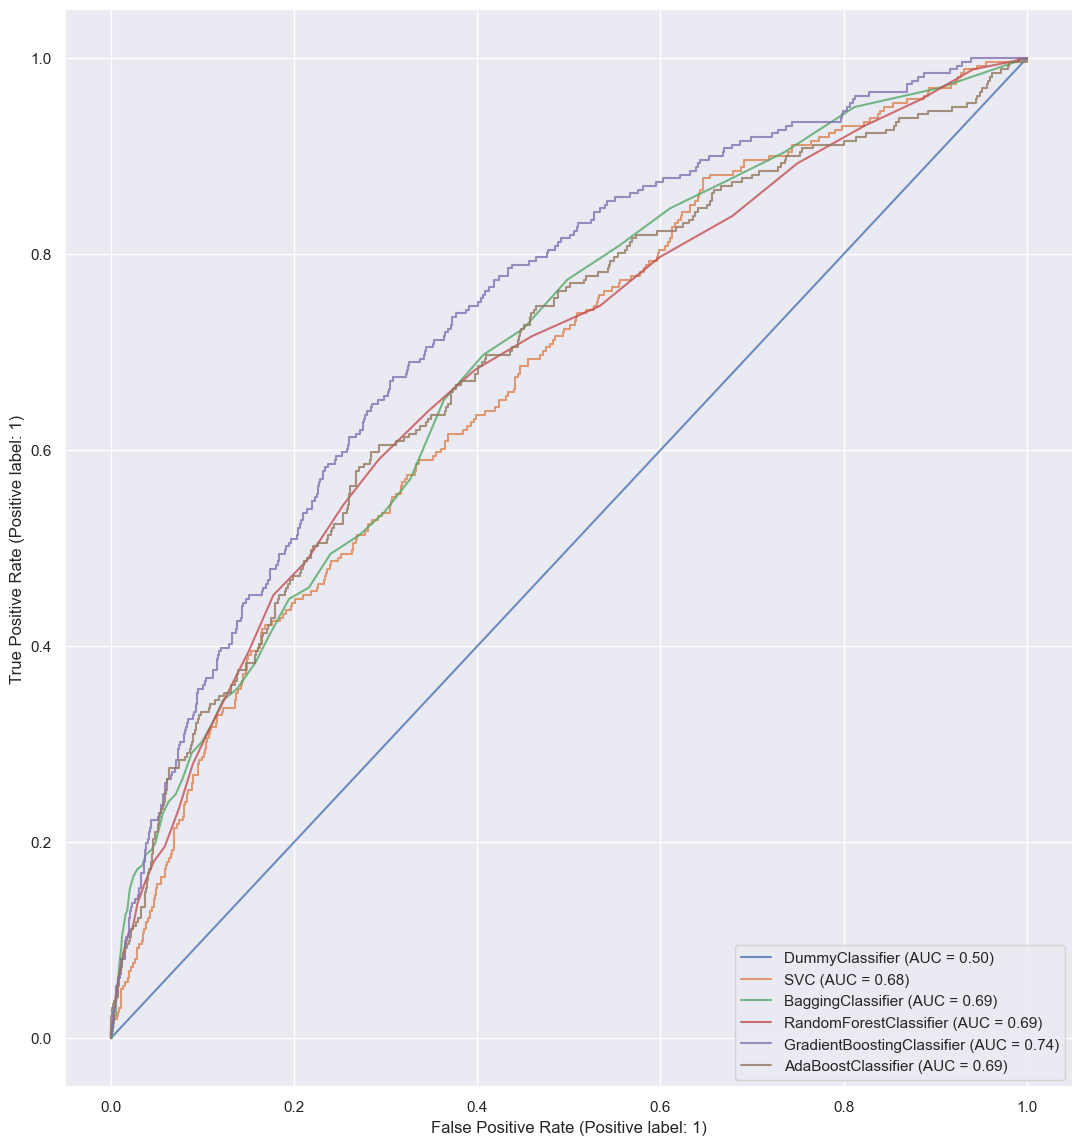

In [36]:
fig, (ax1) = plt.subplots(1, 1, figsize=(13, 14))

with timer("DummyClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=dummy.DummyClassifier(strategy='most_frequent'),
                   display_importance=False)

with timer("SCV"):
    exec_estimator(ax1=ax1,
                   scaler=preprocessing.StandardScaler(),
                   estimator=svm.SVC(kernel='rbf', random_state= RANDOM_STATE, probability=True),
                   display_importance=False)

with timer("BaggingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.BaggingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   display_importance=False)
    
with timer("RandomForestClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.RandomForestClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   display_importance=False)
    
with timer("GradientBoostingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   display_importance=False)
    
with timer("AdaBoostClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.AdaBoostClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   display_importance=False)

del fig, ax1
gc.collect()

## Suppression des colonnes dont le taux de remplissage est inférieur à 40%

Fit DummyClassifier
shape after column treshold: (307511, 459)
shape after process na by mean: (307511, 459)
shape after sampling 10000 rows: (10000, 459)
Parametres:
{'estimator': DummyClassifier(strategy='most_frequent'),
 'estimator__constant': None,
 'estimator__random_state': None,
 'estimator__strategy': 'most_frequent',
 'memory': None,
 'steps': [('estimator', DummyClassifier(strategy='most_frequent'))],
 'verbose': False}
Score: 0.500
Training - éxécuté en 0s
ROC Curve displaying - éxécuté en 0s
DummyClassifier - éxécuté en 3s
Fit SVC
shape after column treshold: (307511, 459)
shape after process na by mean: (307511, 459)
shape after sampling 10000 rows: (10000, 459)
Parametres:
{'estimator': SVC(probability=True, random_state=190276),
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale'

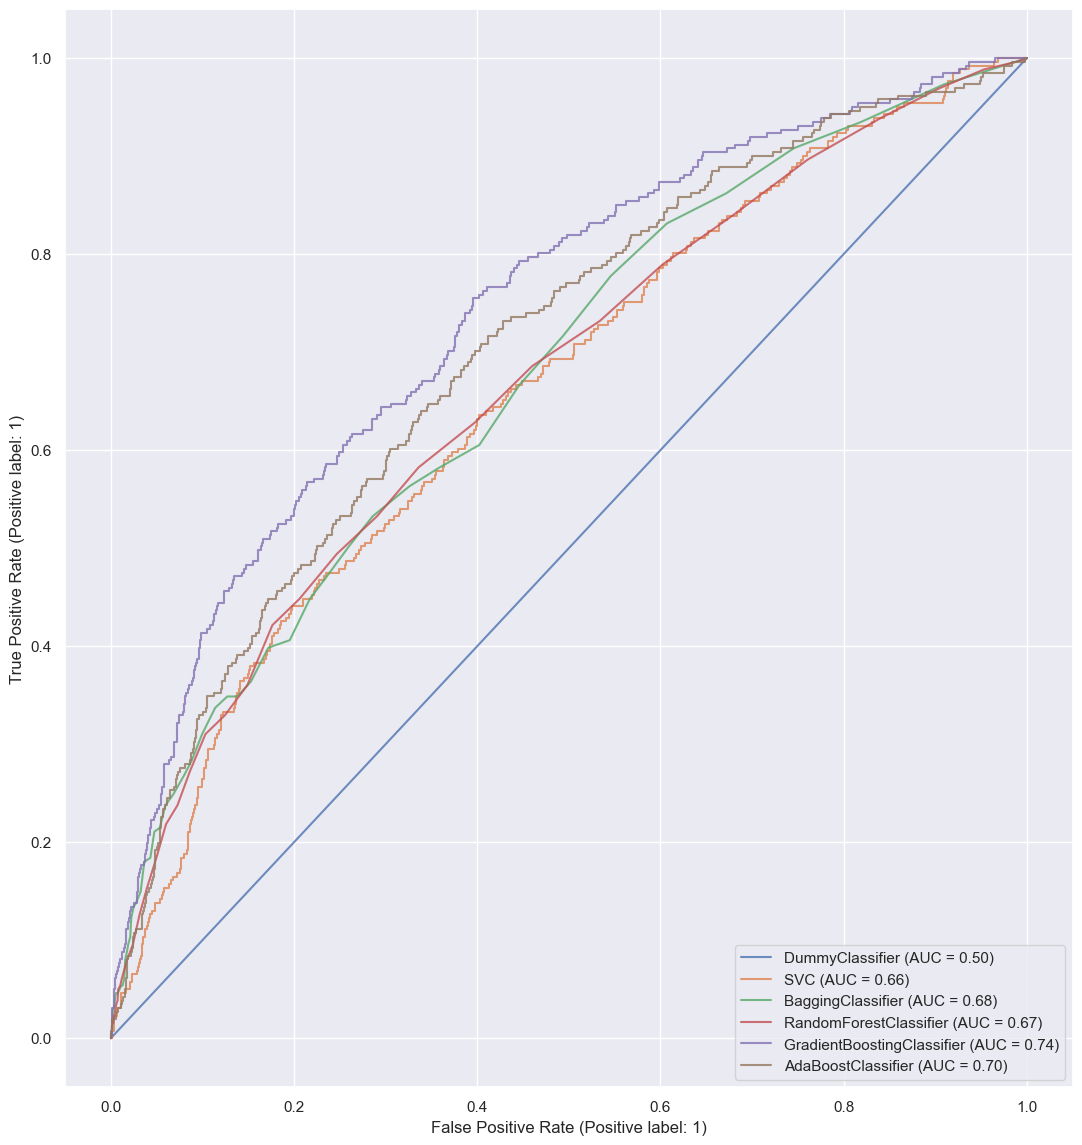

In [37]:
fig, (ax1) = plt.subplots(1, 1, figsize=(13, 14))

DEBUG=True
with timer("DummyClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=dummy.DummyClassifier(strategy='most_frequent'),
                   column_treshold= 60,
                   display_importance=False)

with timer("SCV"):
    exec_estimator(ax1=ax1,
                   scaler=preprocessing.StandardScaler(),
                   estimator=svm.SVC(kernel='rbf', random_state= RANDOM_STATE, probability=True),
                   column_treshold= 60,
                   display_importance=False)

with timer("BaggingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.BaggingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   display_importance=False)
    
with timer("RandomForestClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.RandomForestClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   display_importance=False)
    
with timer("GradientBoostingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   display_importance=False)
    
with timer("AdaBoostClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.AdaBoostClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   display_importance=False)

## Ajout de colonnes polynomials

Fit DummyClassifier
shape after polynomials features addings: (307511, 543)
shape after column treshold: (307511, 475)
shape after process na by mean: (307511, 475)
shape after sampling 10000 rows: (10000, 475)
Parametres:
{'estimator': DummyClassifier(strategy='most_frequent'),
 'estimator__constant': None,
 'estimator__random_state': None,
 'estimator__strategy': 'most_frequent',
 'memory': None,
 'steps': [('estimator', DummyClassifier(strategy='most_frequent'))],
 'verbose': False}
Score: 0.500
Training - éxécuté en 0s
ROC Curve displaying - éxécuté en 0s
DummyClassifier - éxécuté en 4s
Fit SVC
shape after polynomials features addings: (307511, 543)
shape after column treshold: (307511, 475)
shape after process na by mean: (307511, 475)
shape after sampling 10000 rows: (10000, 475)
Parametres:
{'estimator': SVC(probability=True, random_state=190276),
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__

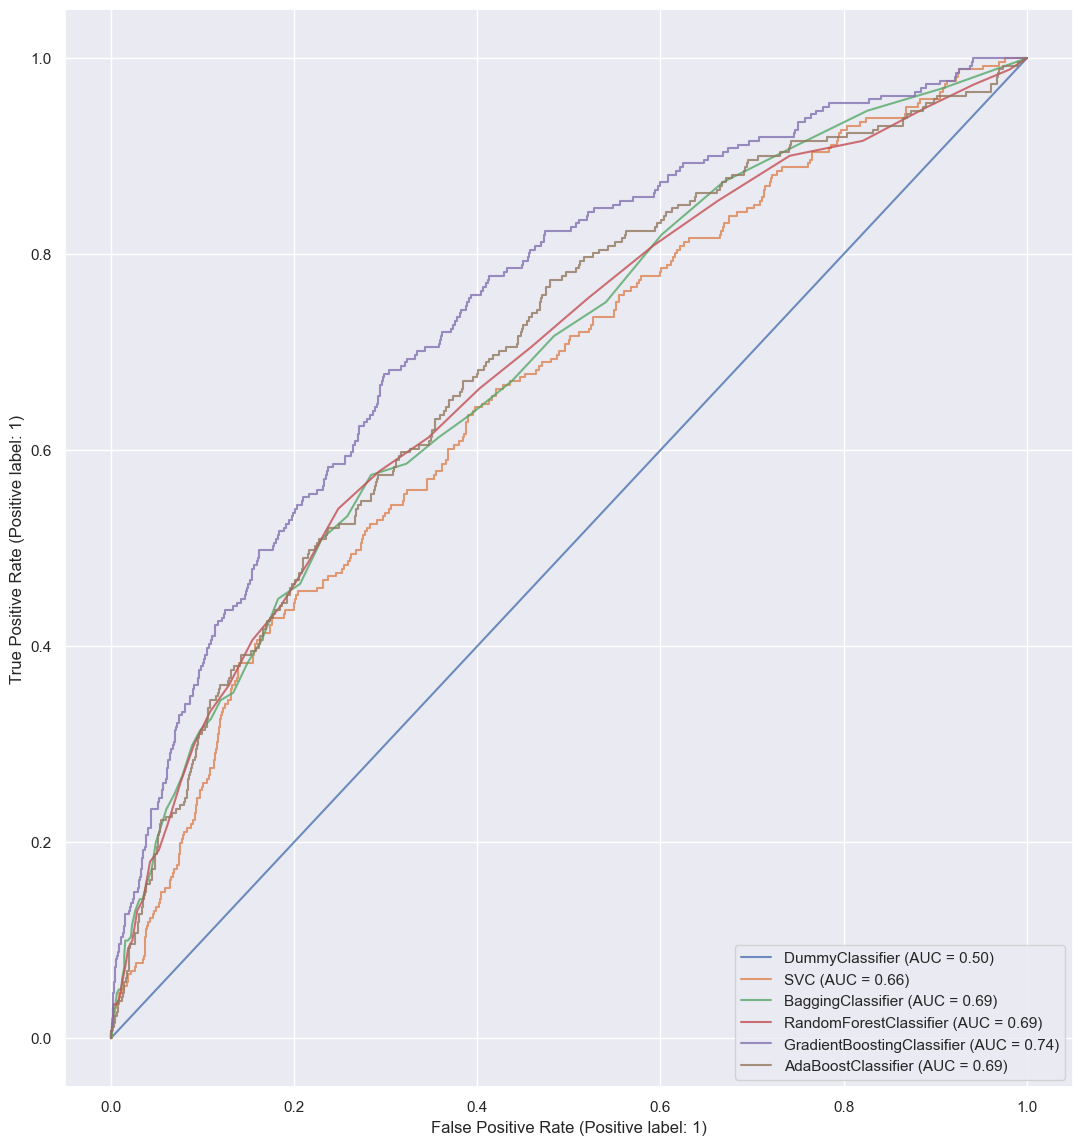

In [38]:
fig, (ax1) = plt.subplots(1, 1, figsize=(13, 14))

DEBUG=True
with timer("DummyClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=dummy.DummyClassifier(strategy='most_frequent'),
                   column_treshold= 60,
                   polynomial_columns=['BUREAU_CREDIT_ACTIVE_Closed_MEAN' ,'CREDIT_CARD_BALANCE_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'PREVIOUS_APPLICATION_AMT_APPLICATION_MEAN'],
                   polynomial_degree=3,
                   display_importance=False)

with timer("SCV"):
    exec_estimator(ax1=ax1,
                   scaler=preprocessing.StandardScaler(),
                   estimator=svm.SVC(kernel='rbf', random_state= RANDOM_STATE, probability=True),
                   column_treshold= 60,
                   polynomial_columns=['BUREAU_CREDIT_ACTIVE_Closed_MEAN' ,'CREDIT_CARD_BALANCE_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'PREVIOUS_APPLICATION_AMT_APPLICATION_MEAN'],
                   polynomial_degree=3,
                   display_importance=False)

with timer("BaggingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.BaggingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   polynomial_columns=['BUREAU_CREDIT_ACTIVE_Closed_MEAN' ,'CREDIT_CARD_BALANCE_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'PREVIOUS_APPLICATION_AMT_APPLICATION_MEAN'],
                   polynomial_degree=3,
                   display_importance=False)
    
with timer("RandomForestClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.RandomForestClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   polynomial_columns=['BUREAU_CREDIT_ACTIVE_Closed_MEAN' ,'CREDIT_CARD_BALANCE_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'PREVIOUS_APPLICATION_AMT_APPLICATION_MEAN'],
                   polynomial_degree=3,
                   display_importance=False)
    
with timer("GradientBoostingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   polynomial_columns=['BUREAU_CREDIT_ACTIVE_Closed_MEAN' ,'CREDIT_CARD_BALANCE_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'PREVIOUS_APPLICATION_AMT_APPLICATION_MEAN'],
                   polynomial_degree=3,
                   display_importance=False)
    
with timer("AdaBoostClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.AdaBoostClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   column_treshold= 60,
                   polynomial_columns=['BUREAU_CREDIT_ACTIVE_Closed_MEAN' ,'CREDIT_CARD_BALANCE_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'PREVIOUS_APPLICATION_AMT_APPLICATION_MEAN'],
                   polynomial_degree=3,
                   display_importance=False)

# Bilan entrainements Phase 1

Malgré un temps d'éxécution plus long à l'entrainement face à RandomForestClassifier (3 fois plus rapide) ou AdaBoostClassifier (2 fois plus rapide), le modèle GradientBoostingClassifier réalise une meilleure estimation dans tous les cas de figure, les prochains entrainements ne concerneront que celui-ci

# Entrainement Phase 2: GradientBoostingClassifier

## Recherche de meilleures features polynomiales

### Features polynomiales 1

In [14]:
DEBUG=True

best_score_1 = 0
best_polynomial_columns_1 = []

with timer("GradientBoostingClassifier loop"):
    while best_score_1 < 0.740:
        clear_output(wait=True)
        with timer("GradientBoostingClassifier"):
                score, polynomial_columns = exec_estimator(estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                                            polynomial_columns_randomize=4,
                                            polynomial_degree=3, 
                                            print_score_only=True)
                if best_score_1 < score:
                    best_score_1 = score
                    best_polynomial_columns_1 = polynomial_columns
        

print("======================================")
print("             BEST SCORE")
print("======================================")
print(f"Best score: {best_score_1:.3f} with polynomial_columns:")
pprint.pprint(best_polynomial_columns_1)

Fit GradientBoostingClassifier
Score: 0.742
Training - éxécuté en 27s
GradientBoostingClassifier - éxécuté en 32s
GradientBoostingClassifier loop - éxécuté en 130s
             BEST SCORE
Best score: 0.742 with polynomial_columns:
['CREDIT_CARD_BALANCE_CNT_DRAWINGS_CURRENT_MEAN',
 'CREDIT_CARD_BALANCE_SK_DPD_DEF_MAX',
 'PREVIOUS_APPLICATION_CHANNEL_TYPE_Contact center_MEAN',
 'OCCUPATION_TYPE_Core staff']


### Features polynomiales 2

In [18]:
DEBUG=True

best_score_2 = 0
best_polynomial_columns_2 = []

with timer("GradientBoostingClassifier loop"):
    while best_score_2 < 0.750:
        clear_output(wait=True)
        with timer("GradientBoostingClassifier"):
                score, polynomial_columns = exec_estimator(estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                                            polynomial_columns_randomize=4,
                                            polynomial_degree=3, 
                                            print_score_only=True)
                if best_score_2 < score:
                    best_score_2 = score
                    best_polynomial_columns_2 = polynomial_columns
        

print("======================================")
print("             BEST SCORE")
print("======================================")
print(f"Best score: {best_score_2:.3f} with polynomial_columns:")
pprint.pprint(best_polynomial_columns_2)

Fit GradientBoostingClassifier
Score: 0.750
Training - éxécuté en 30s
GradientBoostingClassifier - éxécuté en 35s
GradientBoostingClassifier loop - éxécuté en 3719s
             BEST SCORE
Best score: 0.750 with polynomial_columns:
['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
 'FLOORSMIN_MEDI',
 'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
 'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN']


## Recupération des 40 colonnes ayant les importances les plus élévés (en valeur absolue)

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column treshold: (307511, 489)
shape after process na by mean: (307511, 489)
shape after sampling 10000 rows: (10000, 489)
Parametres:
{'estimator': GradientBoostingClassifier(random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'memory': None,
 'st

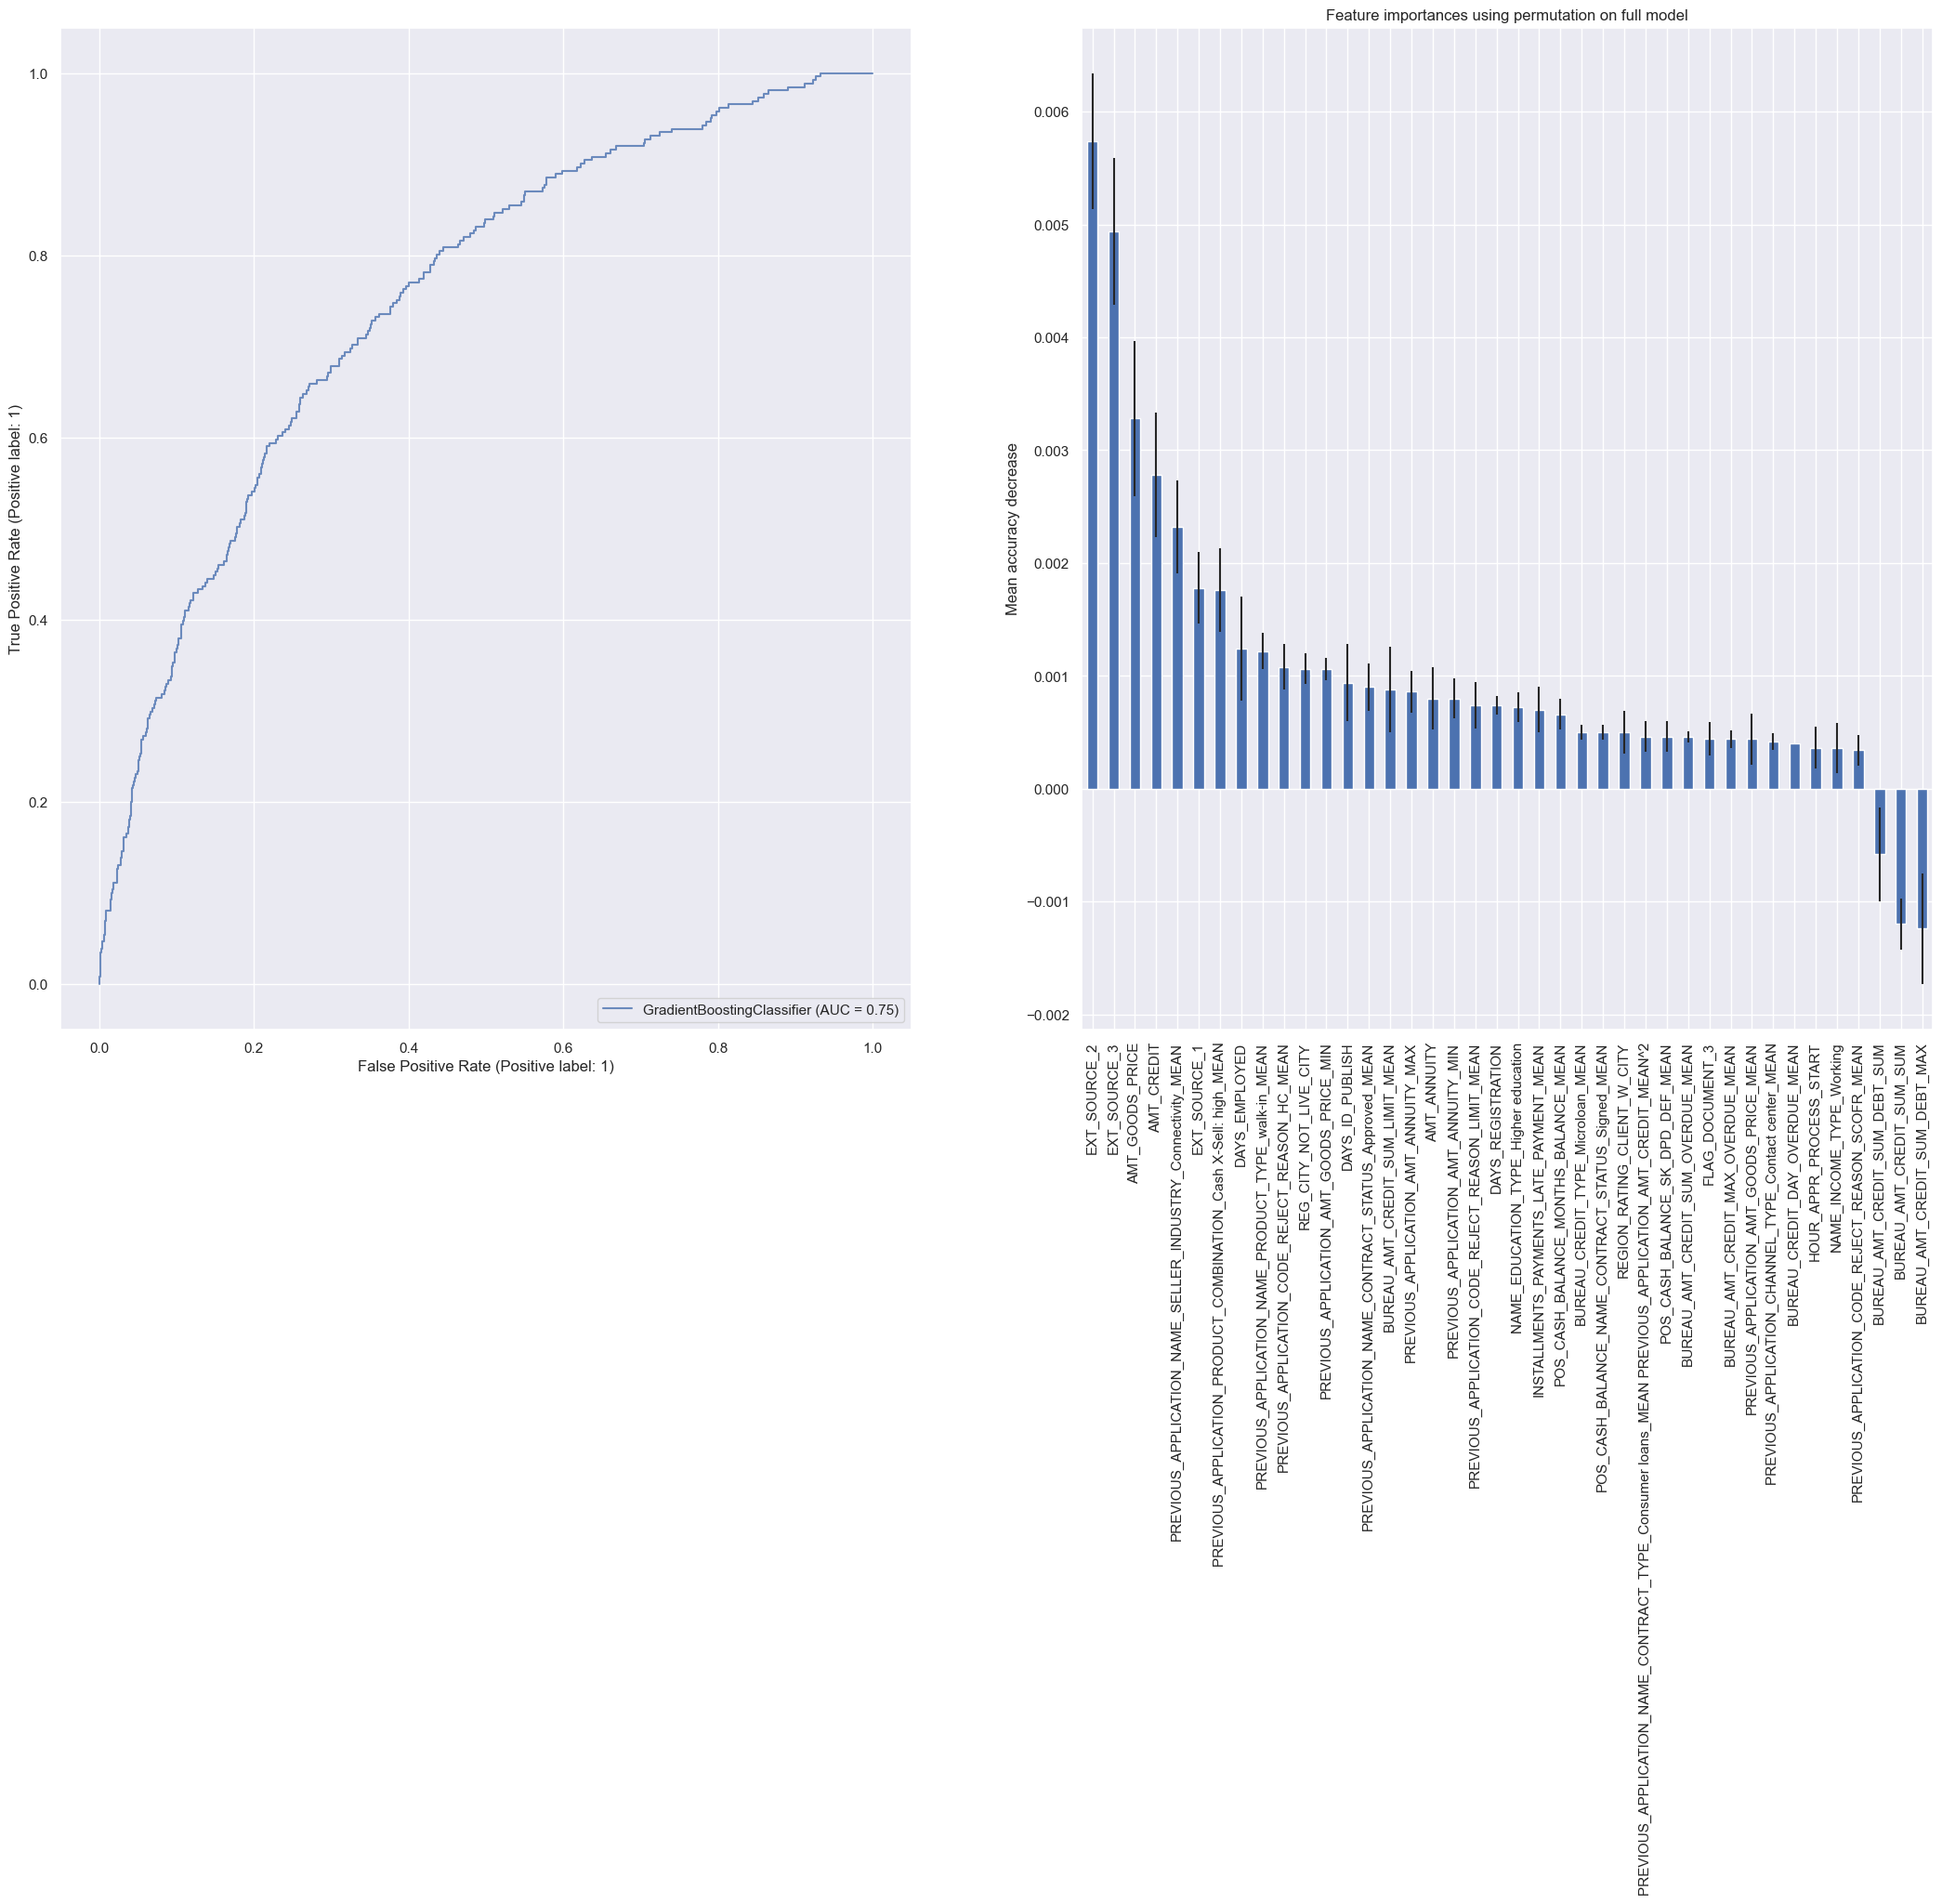

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))

DEBUG=True
with timer("GradientBoostingClassifier"):
    importances, best_estimator, df_test = exec_estimator(ax1=ax1,
                                                          ax2=ax2,
                                                          column_treshold=60,
                                                          estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                                                          polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                                                              'FLOORSMIN_MEDI',
                                                                              'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                                                              'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                                                          polynomial_degree=3,
                                                          importances_limit=40,
                                                          display_importance=True
                                                         )

## Refit en utilisant uniquement les 40 colonnes importantes

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column select: (307511, 41)
shape after process na by mean: (307511, 41)
shape after sampling 10000 rows: (10000, 41)
Parametres:
{'estimator': GradientBoostingClassifier(random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'memory': None,
 'steps':

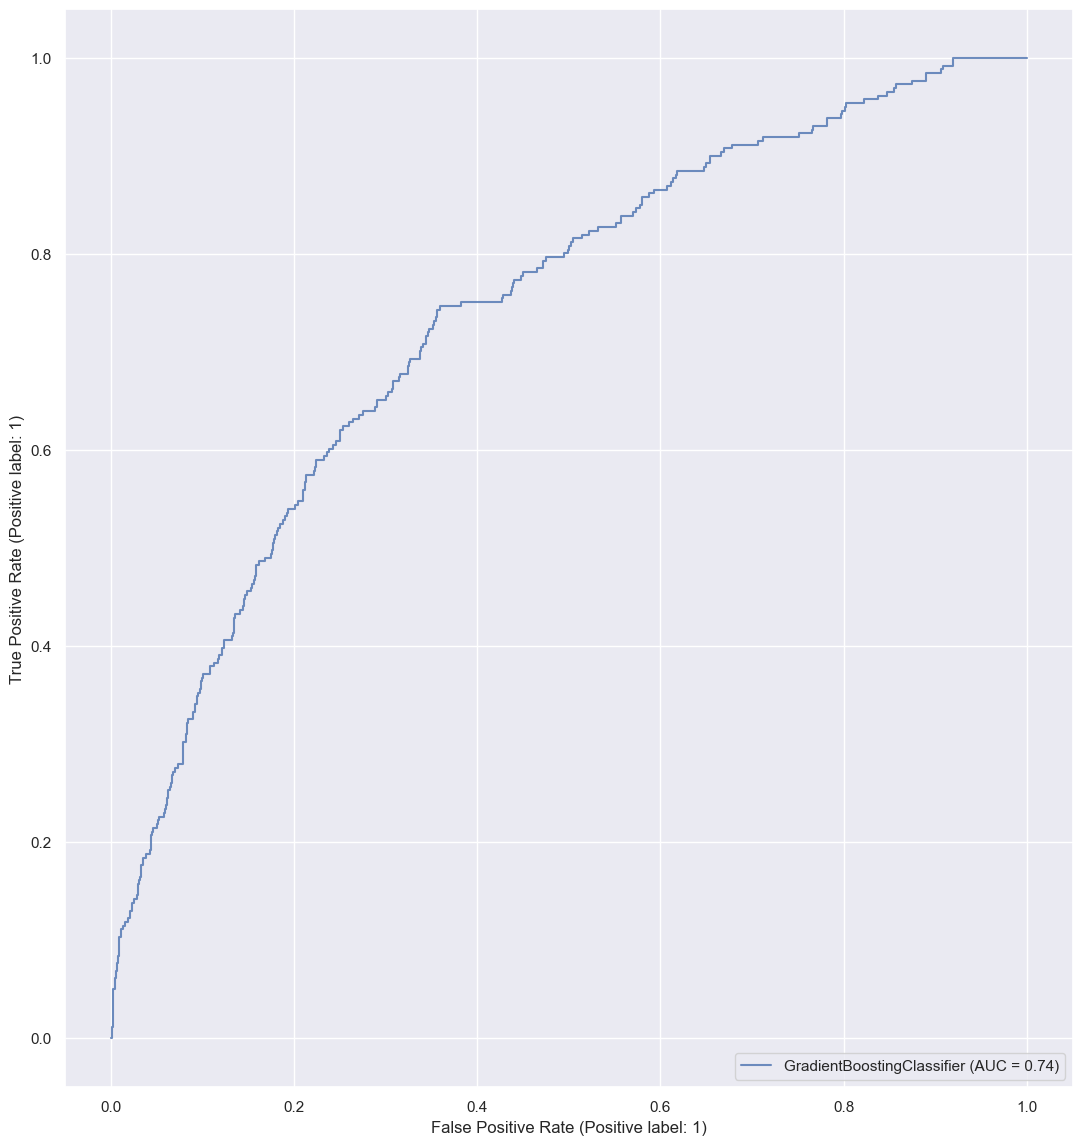

In [20]:
fig, (ax1) = plt.subplots(1, 1, figsize=(13, 14))

DEBUG=True
with timer("GradientBoostingClassifier"):
    _ = exec_estimator(ax1=ax1,
                       ax2=ax2,
                       estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                       polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                           'FLOORSMIN_MEDI',
                                           'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                           'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                       polynomial_degree=3,
                       column_names=list(importances.index)
                      )

## Bilan intermédiaire

En gardant les 40 colonnes les plus importantes, le modèle ne perd que 1.2% en qualité d'estimation mais est 5 fois plus rapide à entrainer

## Ajout de SMOTE sampling

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column select: (307511, 41)
shape after process na by mean: (307511, 41)
shape after sampling 10000 rows: (10000, 41)
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Meilleurs parametres:
{'estimator': GradientBoostingClassifier(random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__

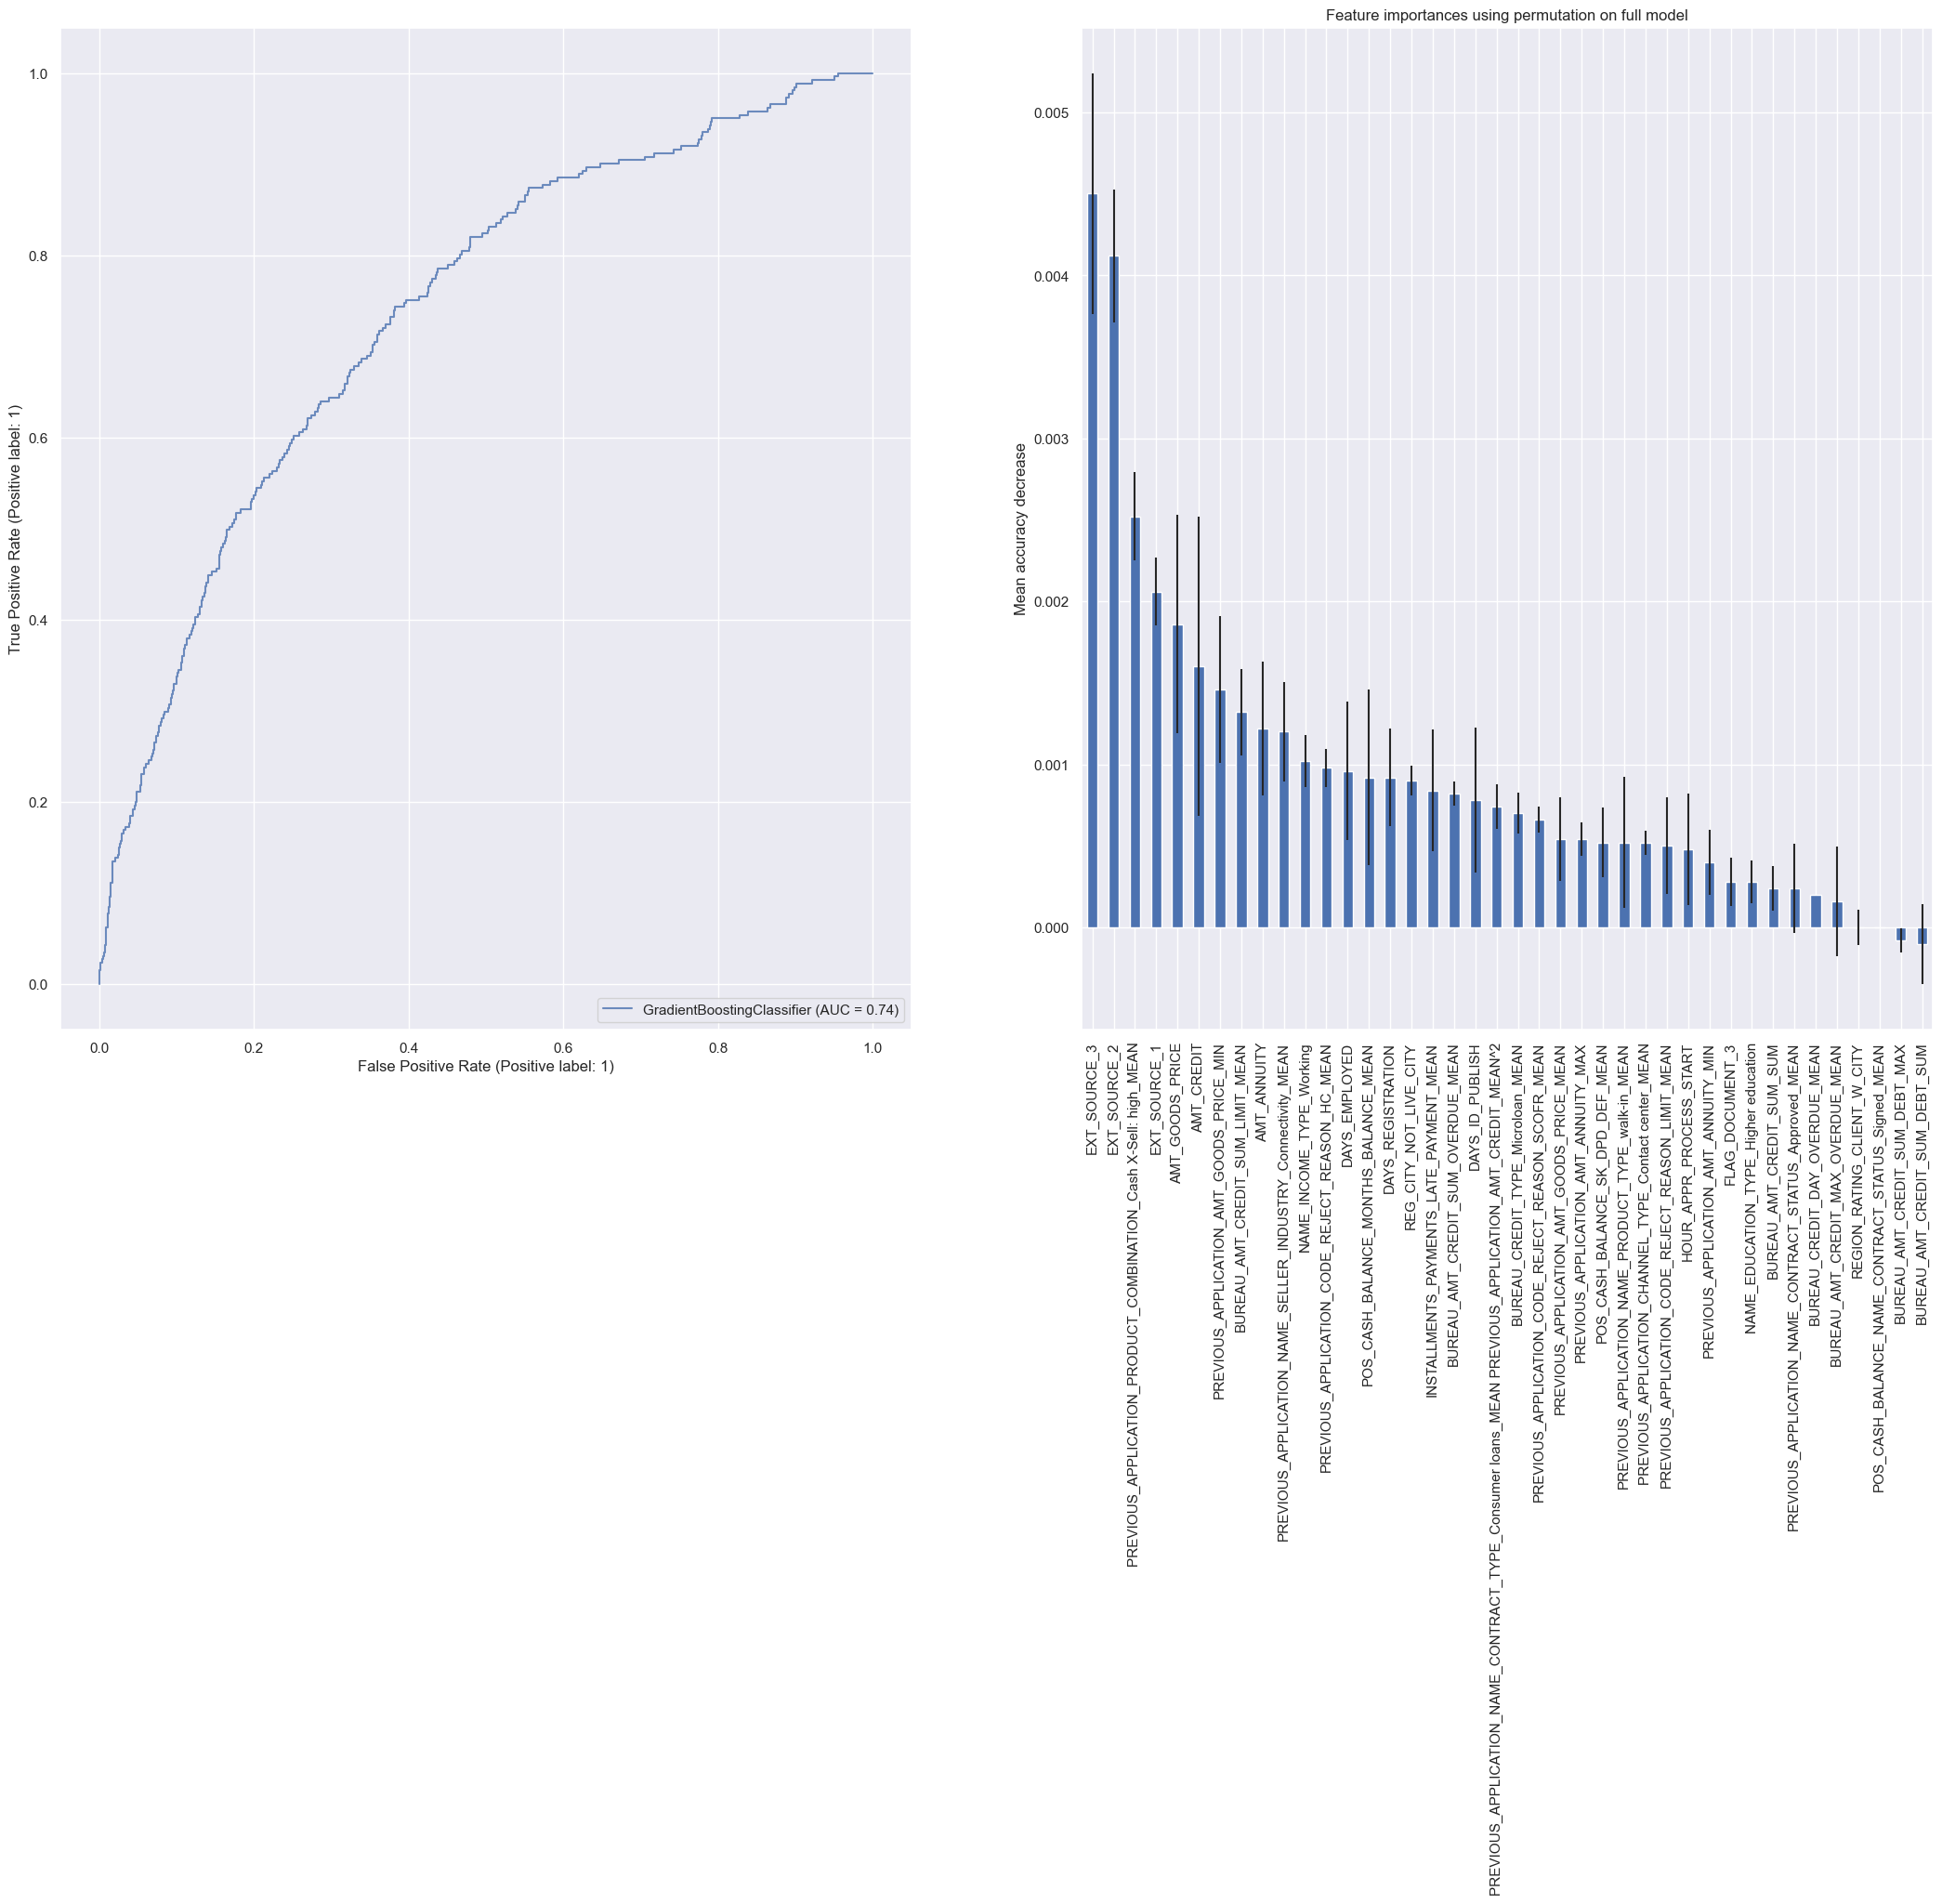

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))

DEBUG=True
with timer("GradientBoostingClassifier"):
    _ = exec_estimator(ax1=ax1,
                       ax2=ax2,
                       estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE),
                       polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                           'FLOORSMIN_MEDI',
                                           'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                           'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                       polynomial_degree=3,
                       column_names=list(importances.index),
                       smote=SMOTE(random_state= RANDOM_STATE),
                       smote_params={'smote__sampling_strategy': np.arange(0.1,1,0.1), 'smote__k_neighbors': [2,3,4,5,6,7]},
                       display_importance=True
                      )

## Grid search for estimator

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column select: (307511, 41)
shape after process na by mean: (307511, 41)
shape after sampling 10000 rows: (10000, 41)
Fitting 3 folds for each of 70 candidates, totalling 210 fits
Meilleurs parametres:
{'estimator': GradientBoostingClassifier(max_depth=2, random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 2,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,


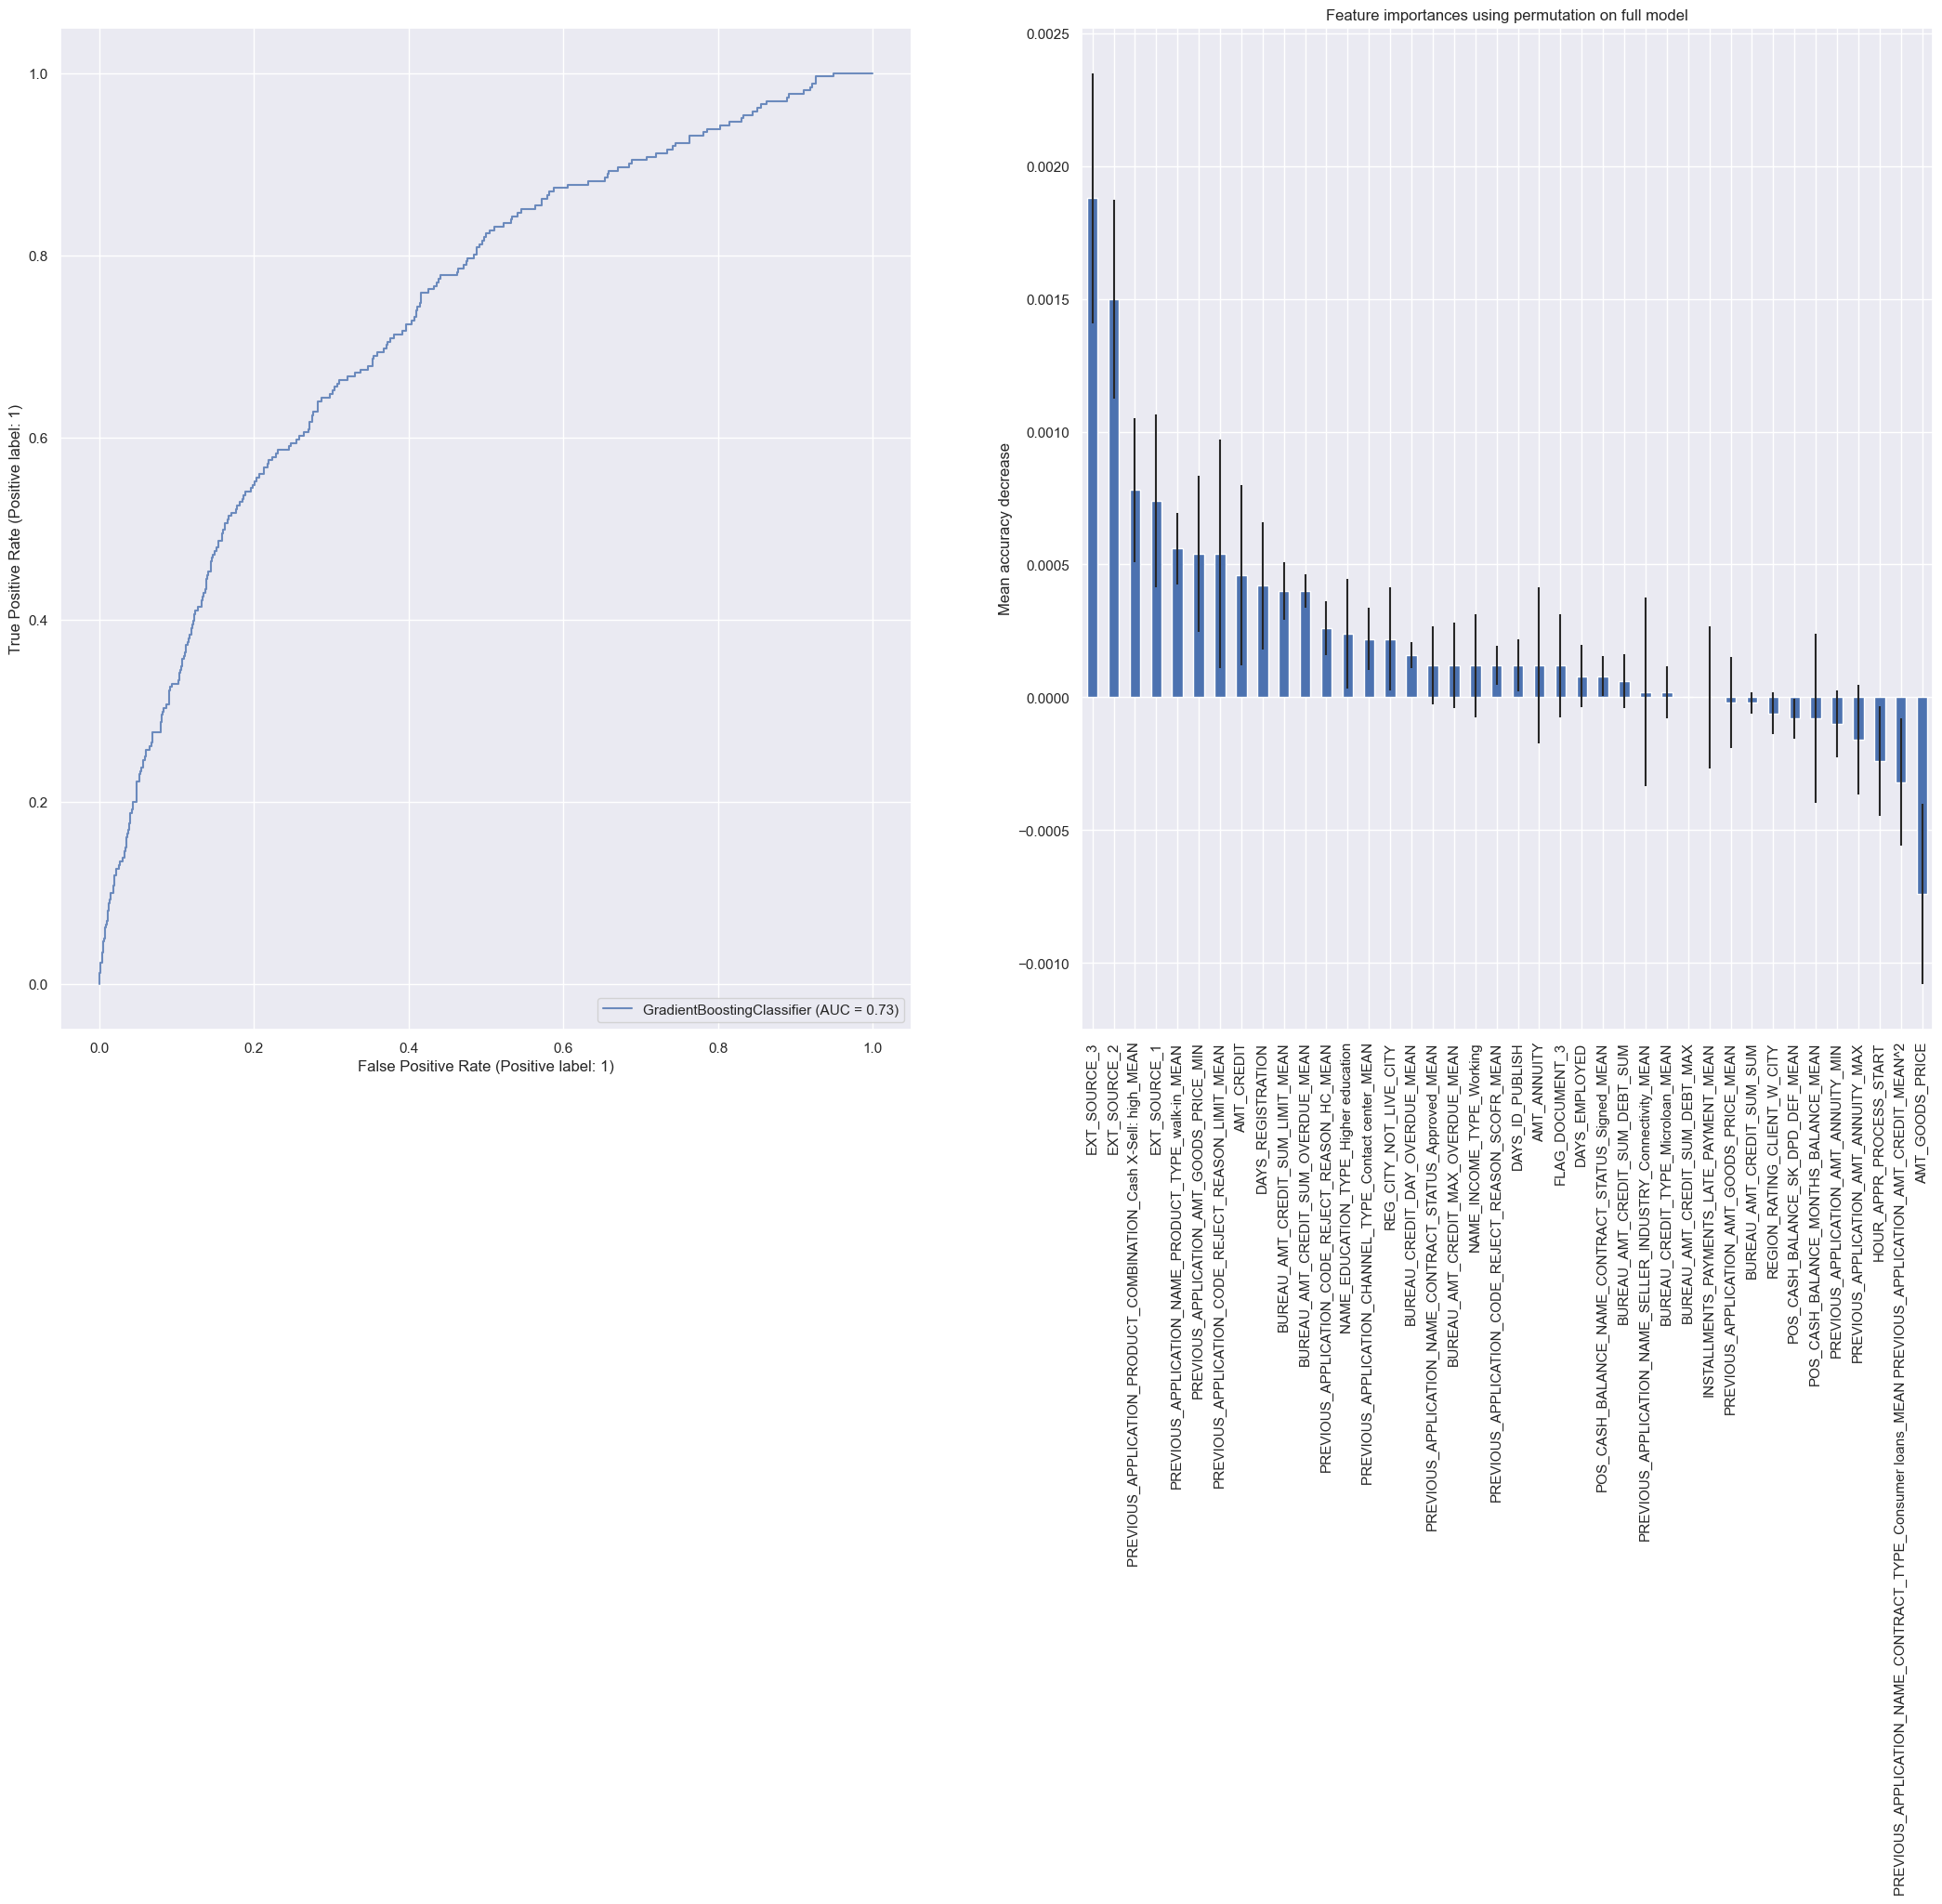

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))

DEBUG=True
with timer("GradientBoostingClassifier"):
    _ = exec_estimator(ax1=ax1,
                       ax2=ax2,
                       estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE),
                       estimator_params={'estimator__n_estimators': [100,500,1000,2000,4000], 'estimator__learning_rate': np.logspace(-3,3,7), 'estimator__max_depth': np.arange(2,4,1)},
                       polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                           'FLOORSMIN_MEDI',
                                           'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                           'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                       polynomial_degree=3,
                       column_names=list(importances.index),
                       smote=SMOTE(random_state= RANDOM_STATE, sampling_strategy=0.1, k_neighbors=3),
                       display_importance=True
                      )

## Random search for estimator

### Randomize 1

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column select: (307511, 41)
shape after process na by mean: (307511, 41)
shape after sampling 10000 rows: (10000, 41)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs parametres:
{'estimator': GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=380,
                           random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.05,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 2,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 380,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 

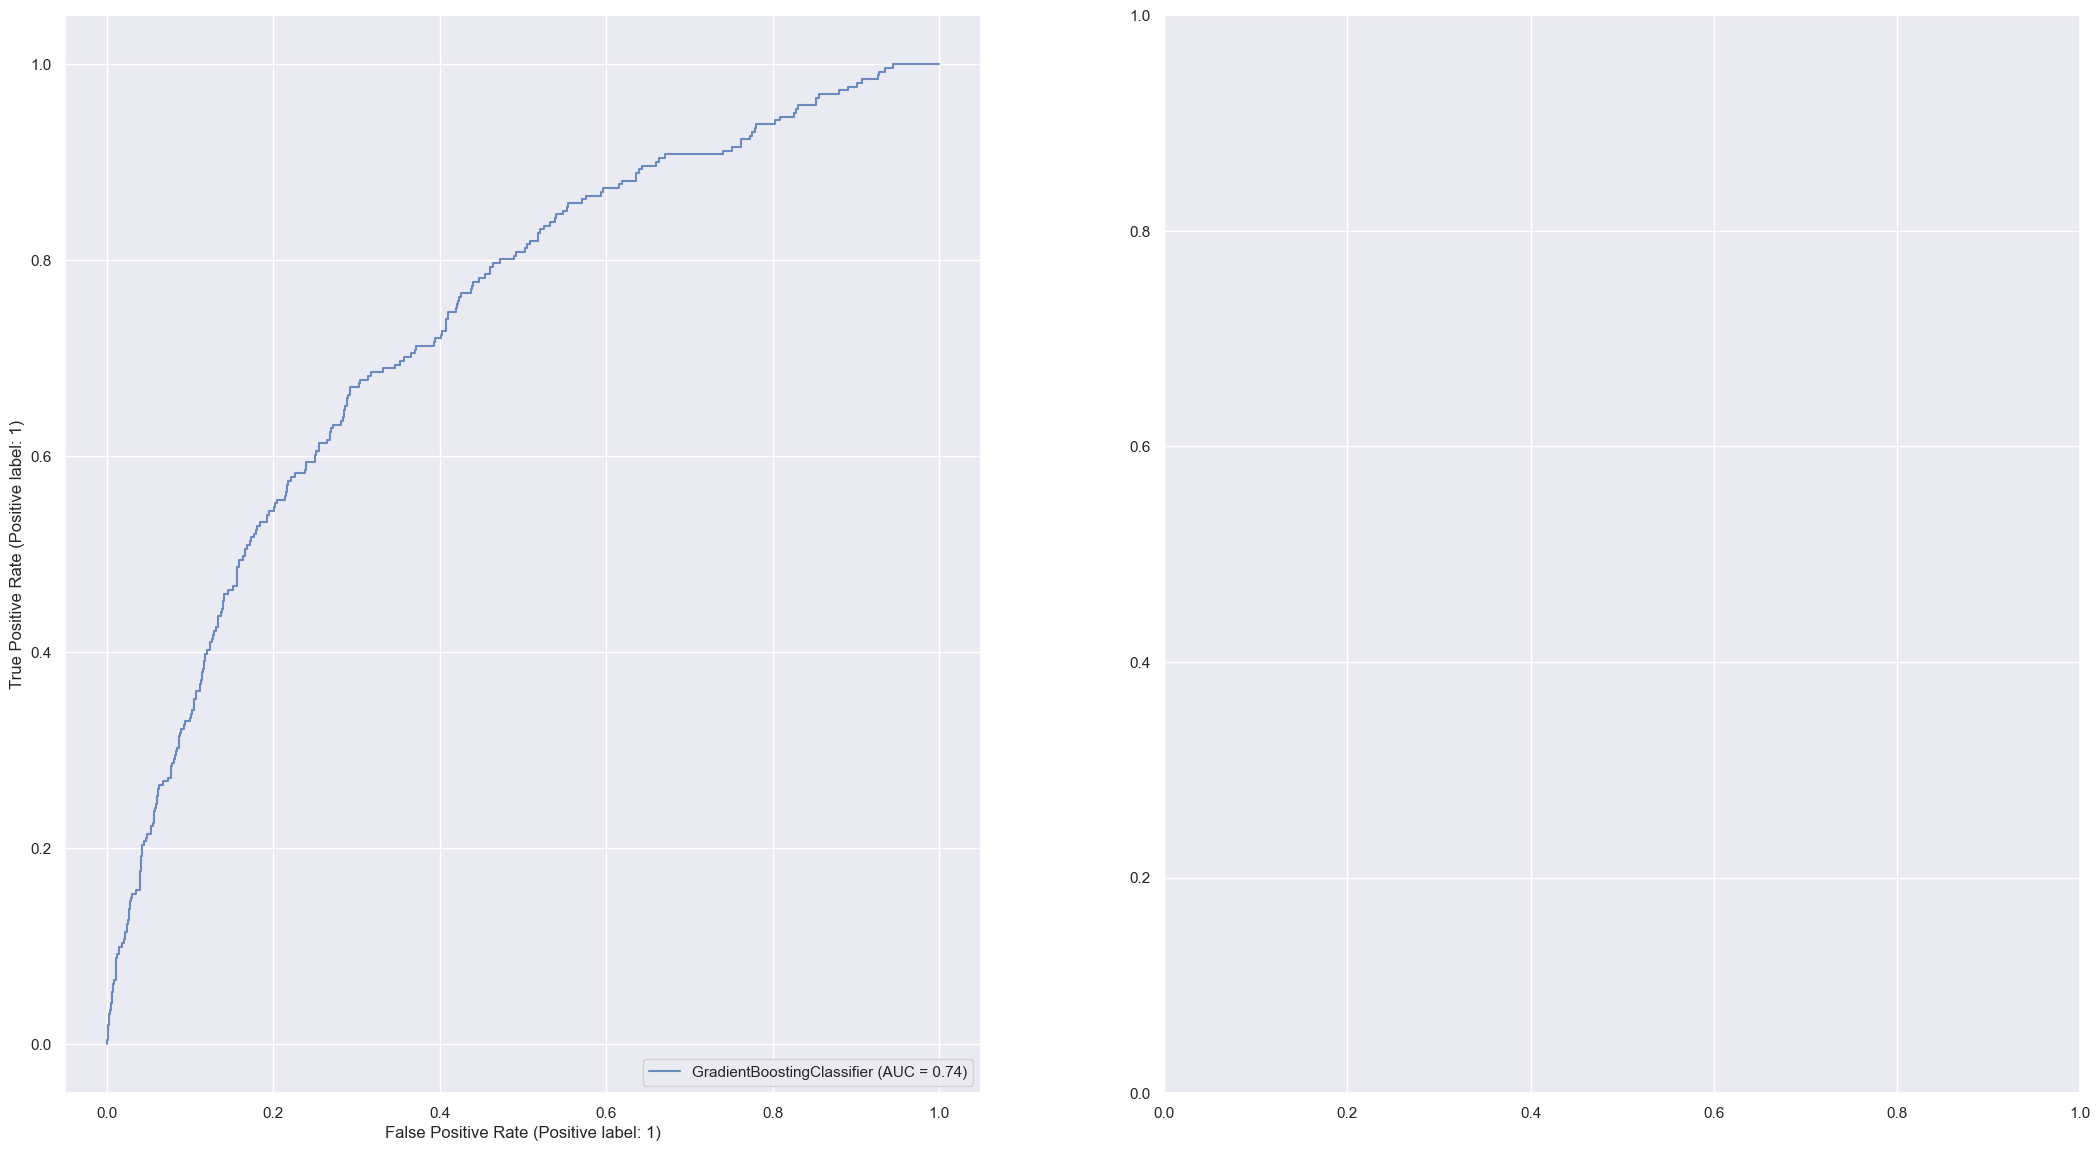

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))

DEBUG=True
with timer("GradientBoostingClassifier"):
    _ = exec_estimator(ax1=ax1,
                       ax2=ax2,
                       estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE),
                       estimator_params={'estimator__n_estimators': np.arange(20,500,10), 'estimator__learning_rate': np.arange(0.05,0.5,0.05), 'estimator__max_depth': [2,3]},
                       randomize=True,
                       randomize_iter=50,
                       polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                           'FLOORSMIN_MEDI',
                                           'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                           'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                       polynomial_degree=3,
                       column_names=list(importances.index),
                       smote=SMOTE(random_state= RANDOM_STATE, sampling_strategy=0.1, k_neighbors=3)
                      )

### Randomize 2

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column select: (307511, 41)
shape after process na by mean: (307511, 41)
shape after sampling 10000 rows: (10000, 41)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs parametres:
{'estimator': GradientBoostingClassifier(learning_rate=0.1, max_depth=2,
                           n_estimators=153, random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 2,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 153,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 'e

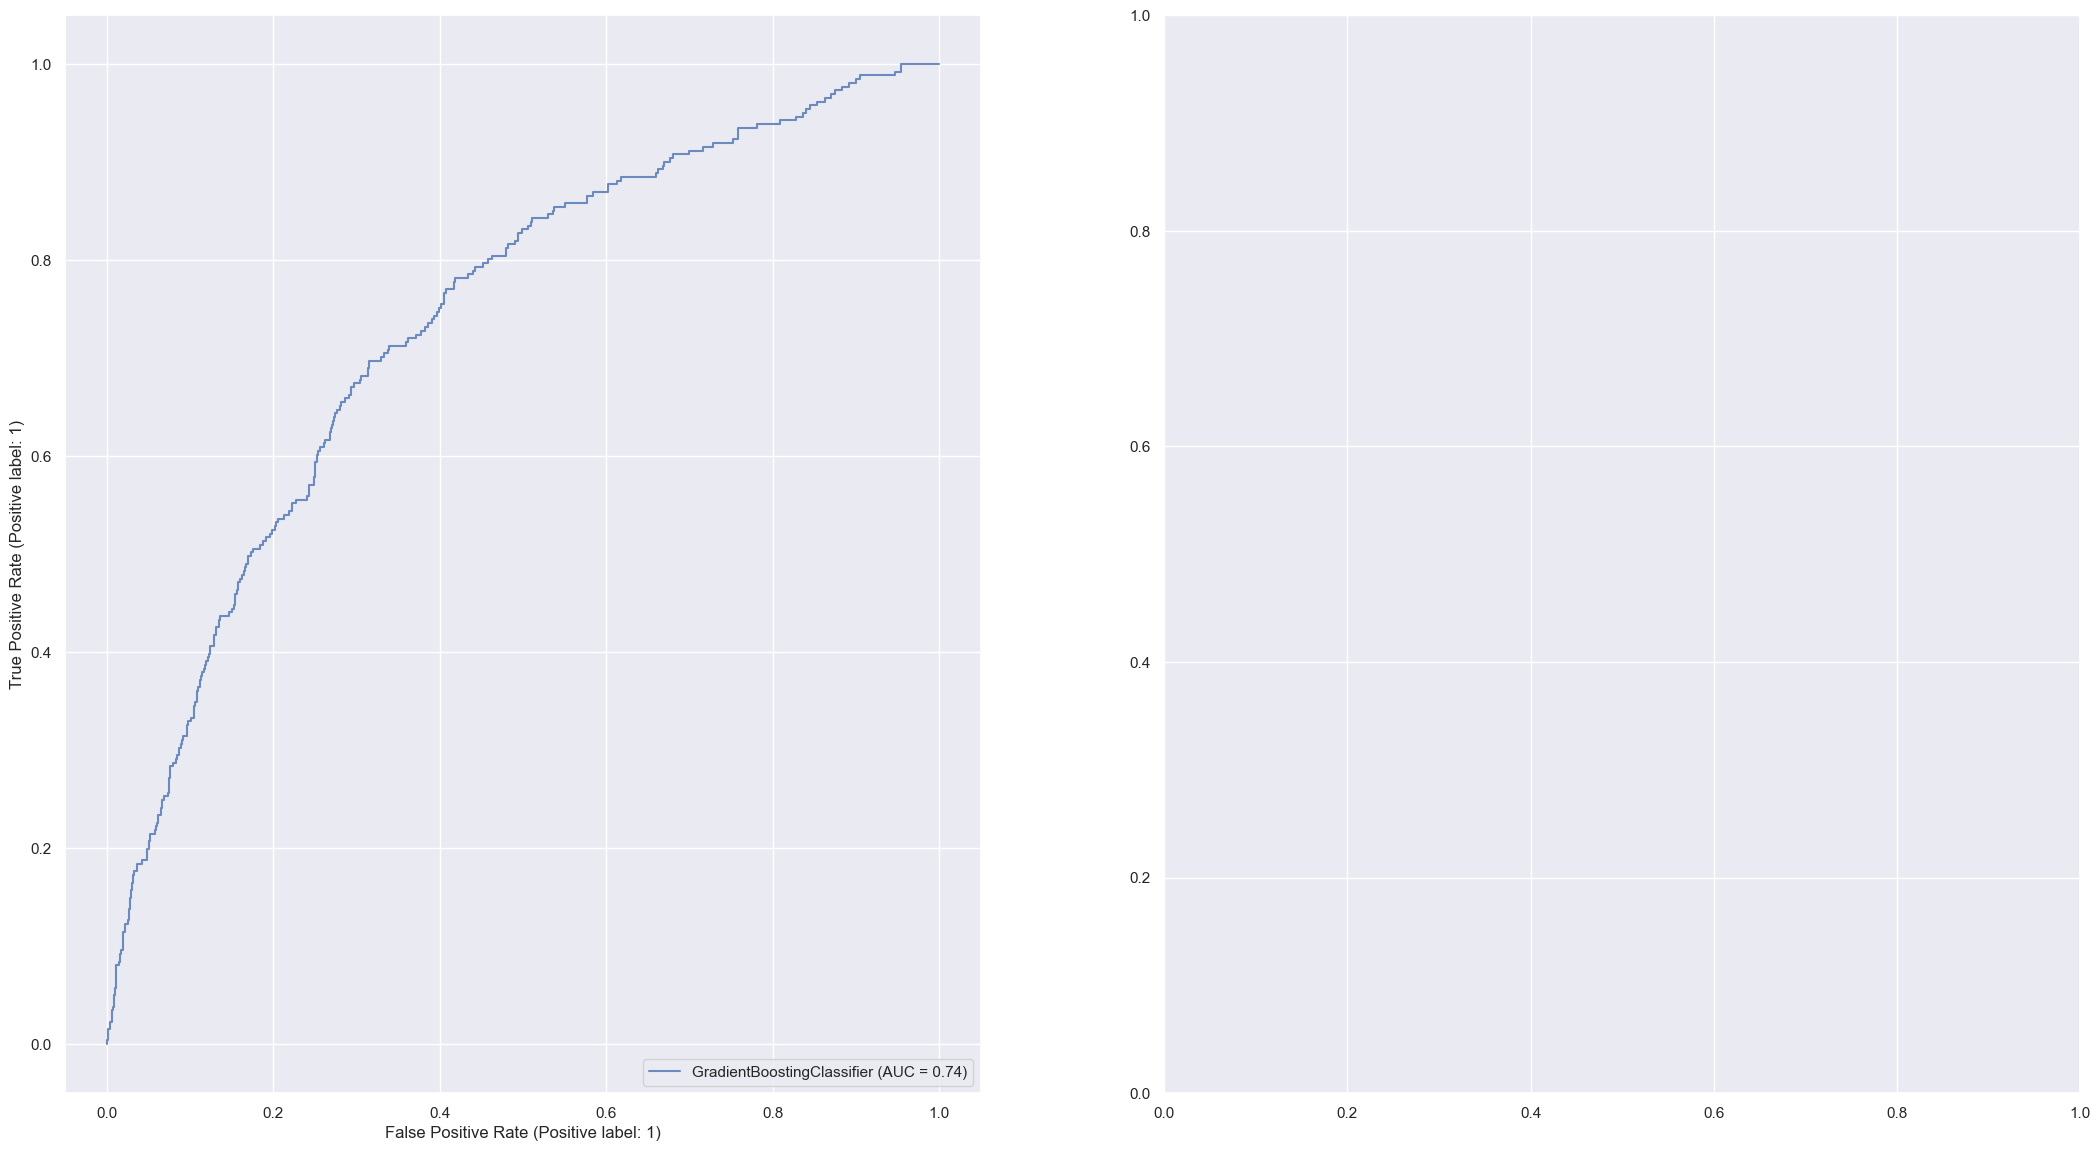

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))

DEBUG=True
with timer("GradientBoostingClassifier"):
    _ = exec_estimator(ax1=ax1,
                       ax2=ax2,
                       estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE),
                       estimator_params={'estimator__n_estimators': np.arange(20,500,1), 'estimator__learning_rate': np.arange(0.05,0.5,0.01), 'estimator__max_depth': [2,3]},
                       randomize=True,
                       randomize_iter=50,
                       polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                           'FLOORSMIN_MEDI',
                                           'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                           'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                       polynomial_degree=3,
                       column_names=list(importances.index),
                       smote=SMOTE(random_state= RANDOM_STATE, sampling_strategy=0.1, k_neighbors=3)
                      )

# Entraînement final

## Avec tout le dataset

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column select: (307511, 41)
shape after process na by mean: (307511, 41)
Parametres:
{'estimator': GradientBoostingClassifier(max_depth=2, n_estimators=153, random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 2,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 153,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'memory': None,
 'smote': SMOTE(k_neigh

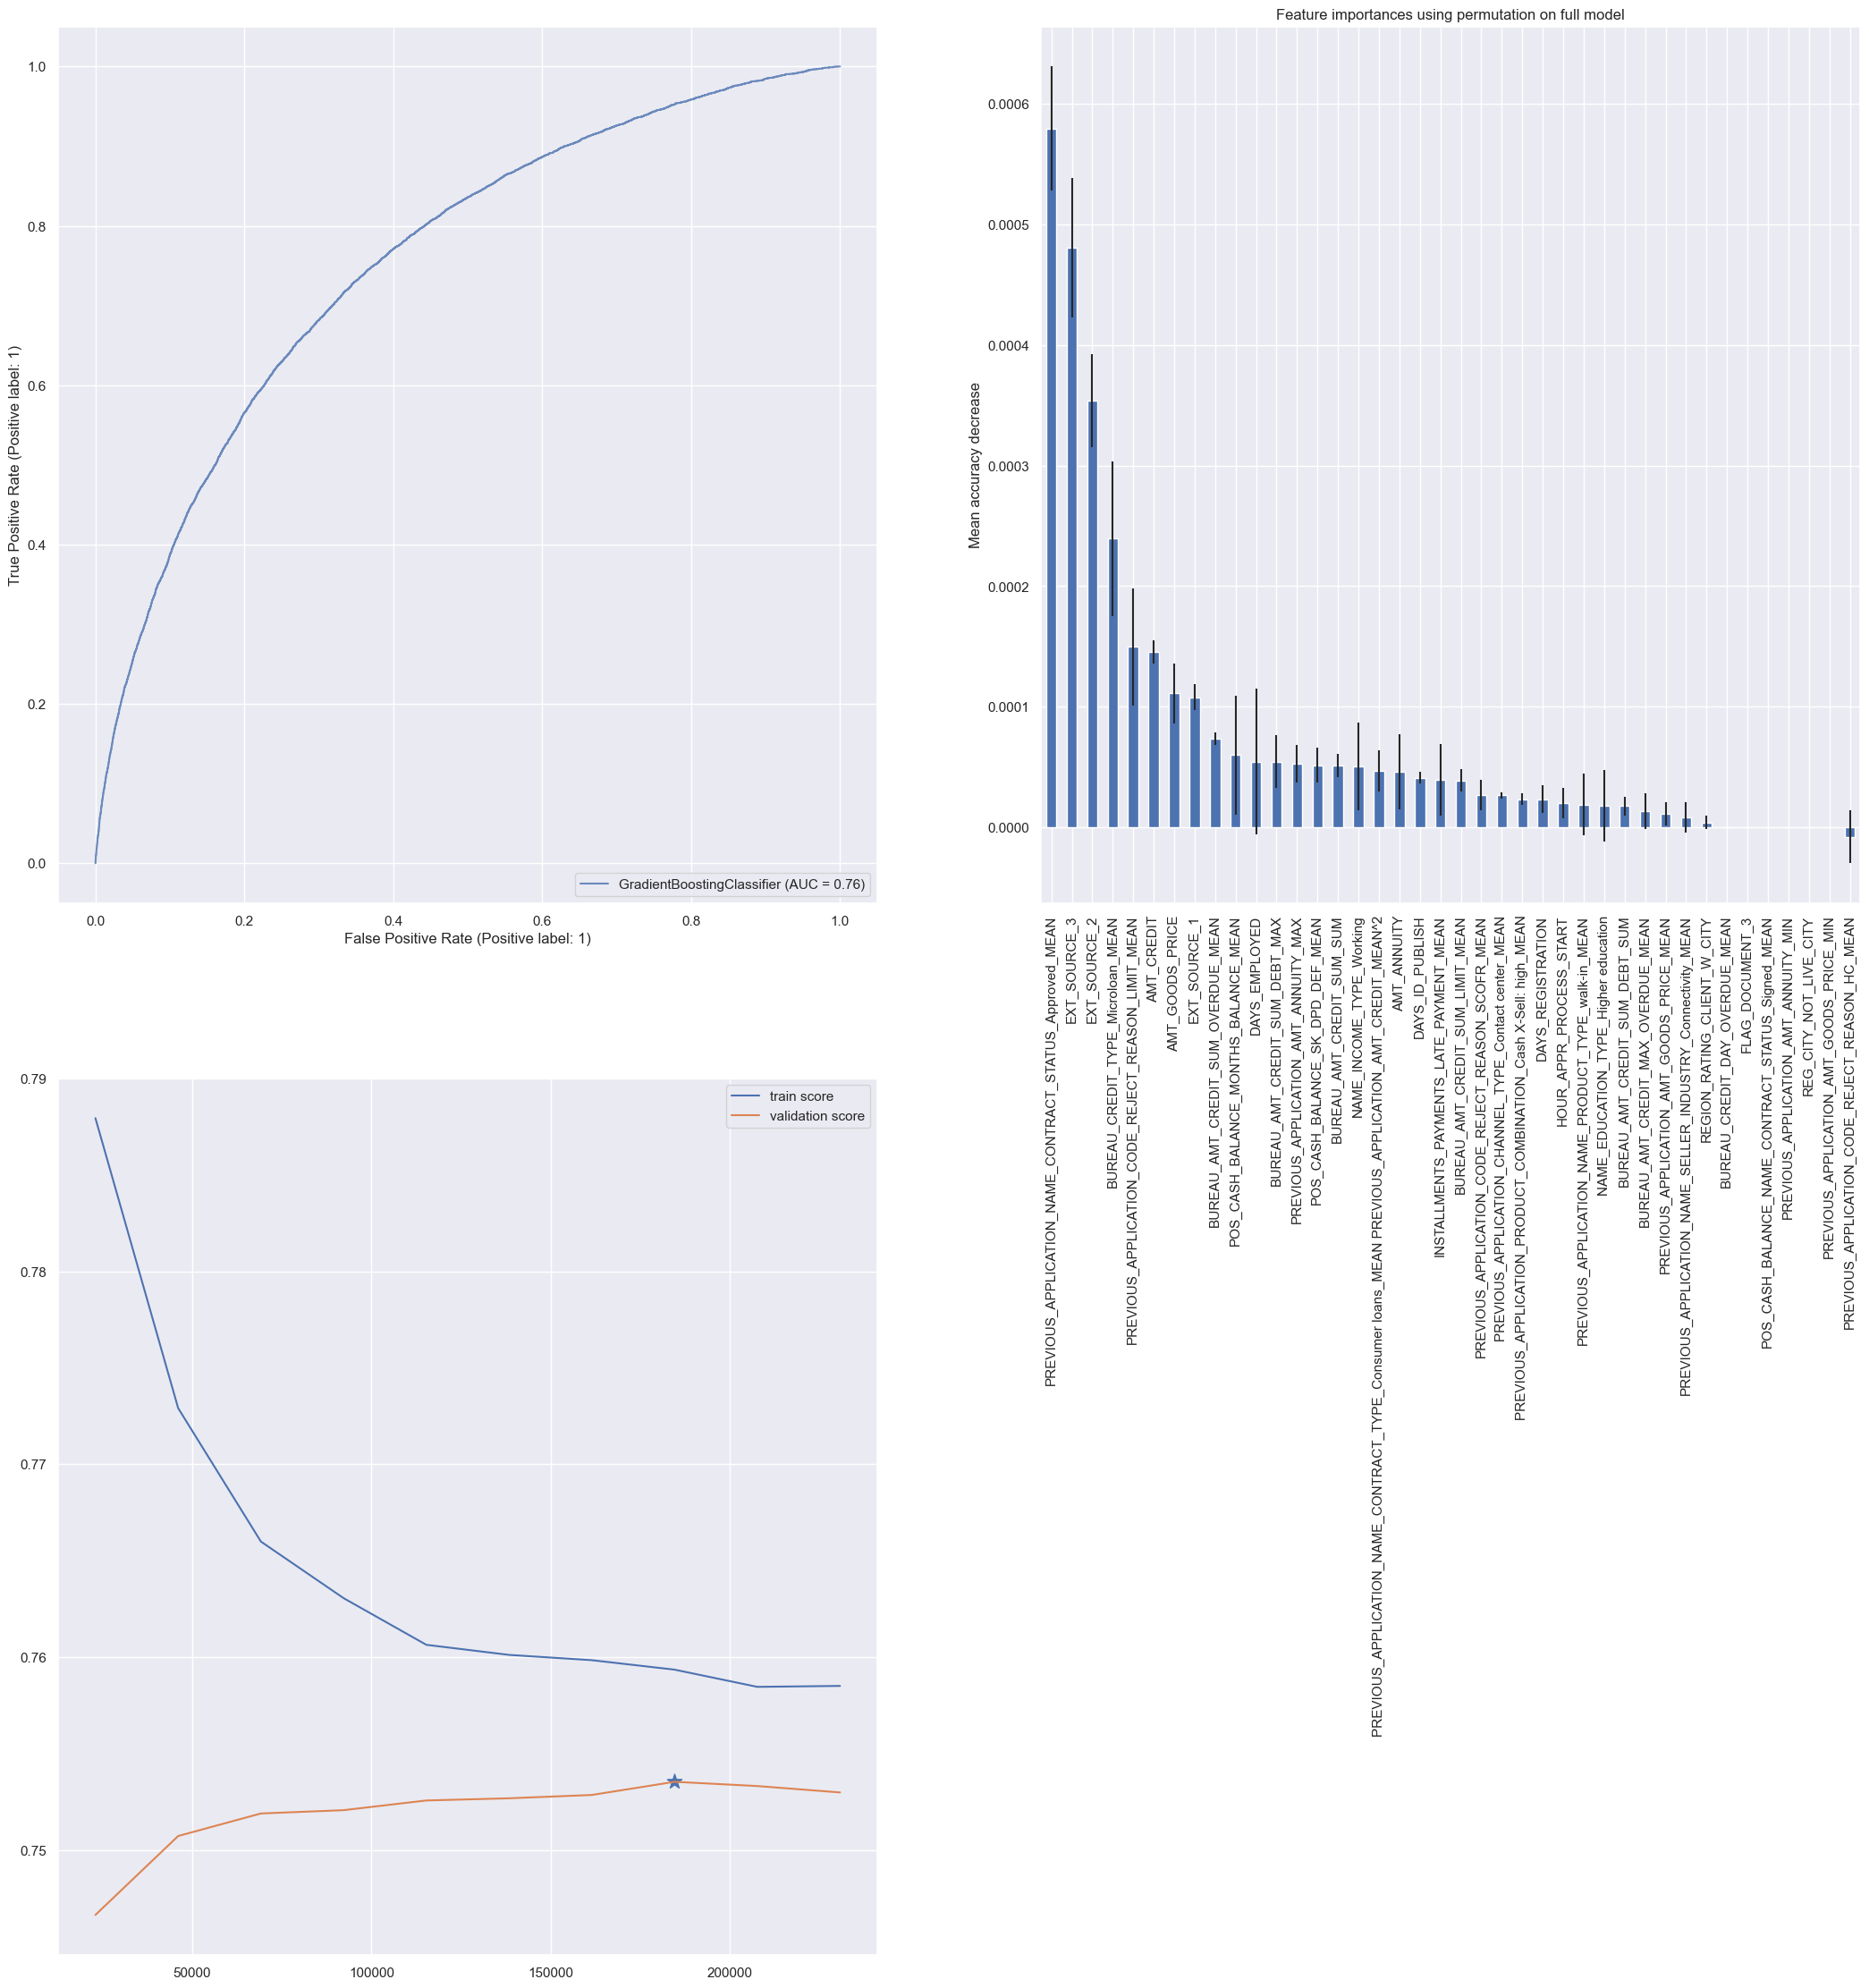

In [27]:
fig = plt.figure(figsize=(26,28))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)

DEBUG = False
with timer("GradientBoostingClassifier"):
    _ = exec_estimator(ax1=ax1,
                       ax2=ax2,
                       ax_learning_curve = ax3,
                       estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=153, learning_rate=0.1, max_depth=2),
                       polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                           'FLOORSMIN_MEDI',
                                           'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                           'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                       polynomial_degree=3,
                       column_names=list(importances.index),
                       smote=SMOTE(random_state= RANDOM_STATE, sampling_strategy=0.1, k_neighbors=3),
                       display_importance=True
                      )

## Avec l'optimum de la learning curve

Fit GradientBoostingClassifier
shape after polynomials features addings: (307511, 557)
shape after column select: (307511, 41)
shape after process na by mean: (307511, 41)
shape after sampling 184506 rows: (184506, 41)
Parametres:
{'estimator': GradientBoostingClassifier(max_depth=2, n_estimators=153, random_state=190276),
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 2,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 153,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 190276,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': 

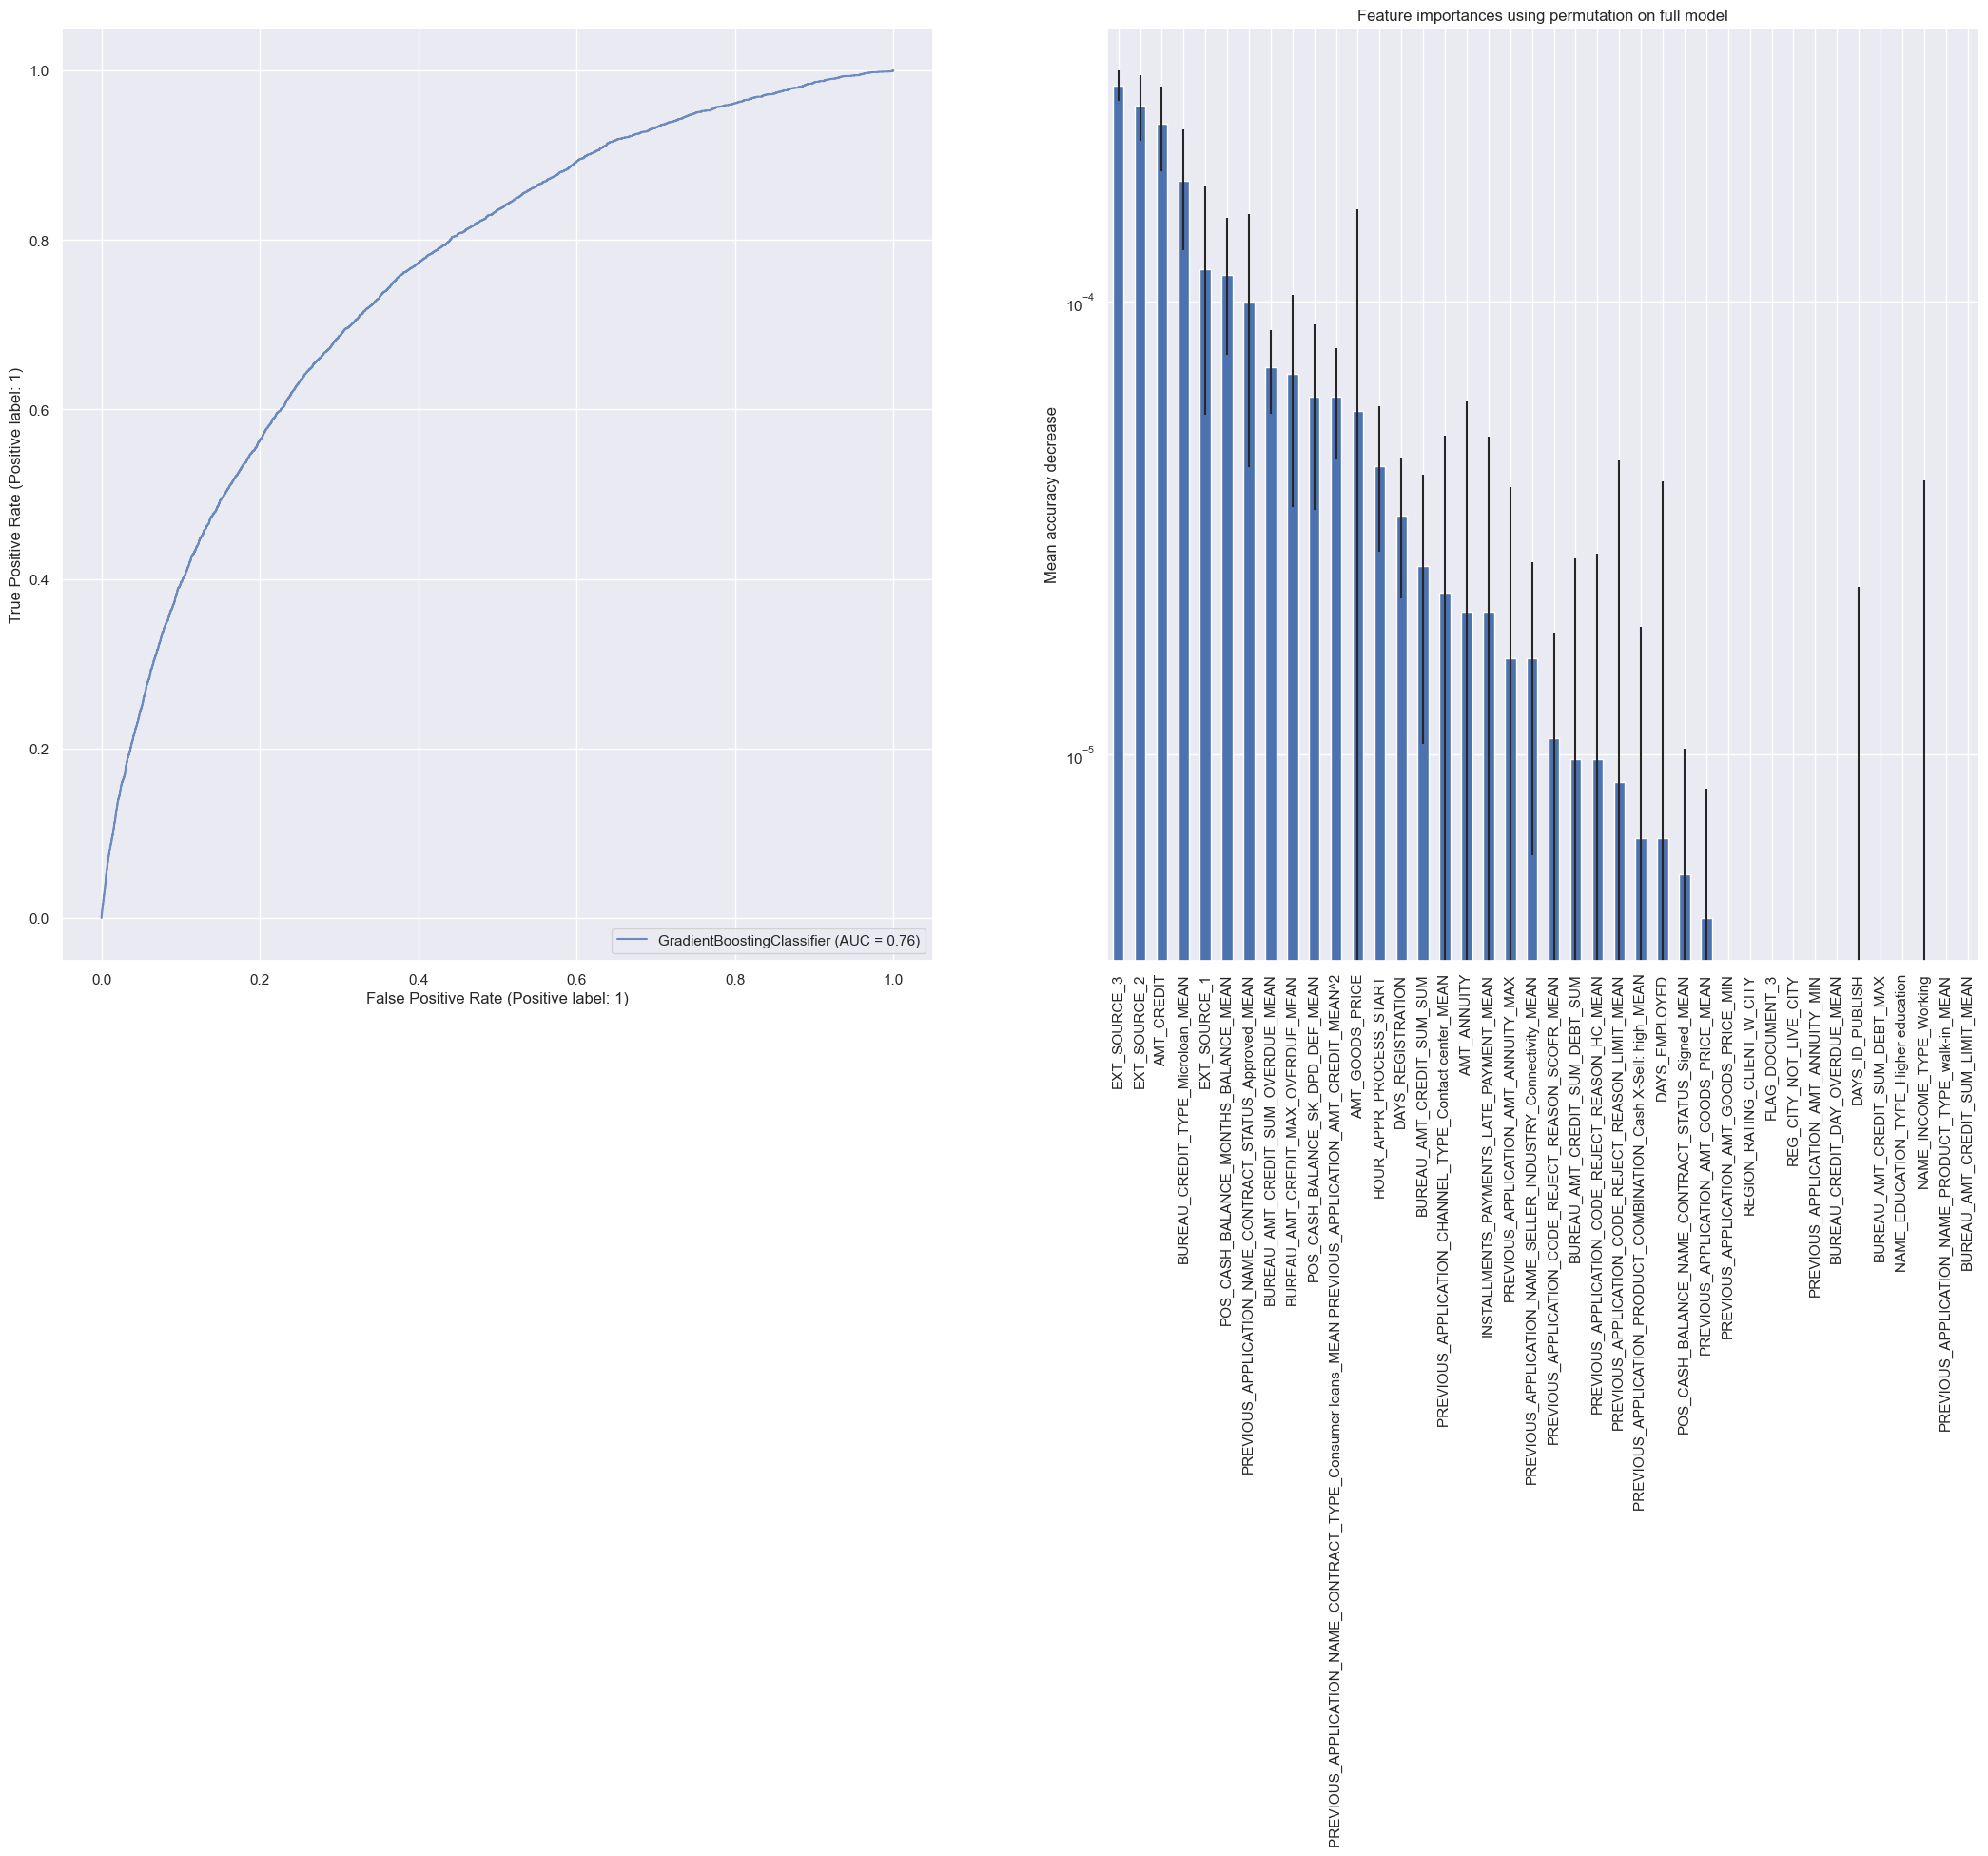

In [14]:
fig = plt.figure(figsize=(26,28))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)

DEBUG = False
with timer("GradientBoostingClassifier"):
    _, estimator, df_test = exec_estimator(ax1=ax1,
                                                ax2=ax2,
                                                estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=153, learning_rate=0.1, max_depth=2),
                                                polynomial_columns=['PREVIOUS_APPLICATION_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                                                                    'FLOORSMIN_MEDI',
                                                                     'PREVIOUS_APPLICATION_AMT_CREDIT_MEAN',
                                                                   'CREDIT_CARD_BALANCE_AMT_DRAWINGS_CURRENT_MEAN'],
                                                polynomial_degree=3,
                                                column_names=list(importances.index),
                                                smote=SMOTE(random_state= RANDOM_STATE, sampling_strategy=0.1, k_neighbors=3),
                                                display_importance=True,
                                                importance_logy=True,
                                                sample=184506
                                               )

# Aller plus loin

## Expliquer une prédiction grâce à la librairie LIME

<b>IMPORTANT: Indiquez "Fiable" pour javascript dans le notebook si vous souhaitez voir le résultat du graphique</b>

<img src="./advertissing.png" alt="drawing" width="1000"/>

In [56]:
# Choix aleatoire d'un element du jeu de test
i = np.random.randint(0, df_test.shape[0])
print(f'Prédiction sur l\'élement n° {i} du jeu de test')
# Affichage des 5 premieres features expliquant la décision
explain_prediction(estimator, df_test, i)

Prédiction sur l'élement n° 47010 du jeu de test


## Score personalisé au lieu de auroc

Scoring qui donne plus d'importance à un faux positif (voir fonction custom_scoring)<br>

<div style="margin-left: 0;
            margin-right: auto;
            width: 10%">
    
Resultat | Points
---|---
Vrai positif | +1
Vrai négatif | +1
Faux négatif | -1
Faux positif | -10
    
</div>    

Plus le score final moyen se rapproche de +2 meilleur on est


Fit DummyClassifier
shape after process na by mean: (307511, 527)
shape after sampling 10000 rows: (10000, 527)
Parametres:
{'estimator': DummyClassifier(strategy='most_frequent'),
 'estimator__constant': None,
 'estimator__random_state': None,
 'estimator__strategy': 'most_frequent',
 'memory': None,
 'steps': [('estimator', DummyClassifier(strategy='most_frequent'))],
 'verbose': False}
Score: 0.043
Training - éxécuté en 0s
Score displaying - éxécuté en 0s
DummyClassifier - éxécuté en 4s
Fit SVC
shape after process na by mean: (307511, 527)
shape after sampling 10000 rows: (10000, 527)
Parametres:
{'estimator': SVC(probability=True, random_state=190276),
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': True

0

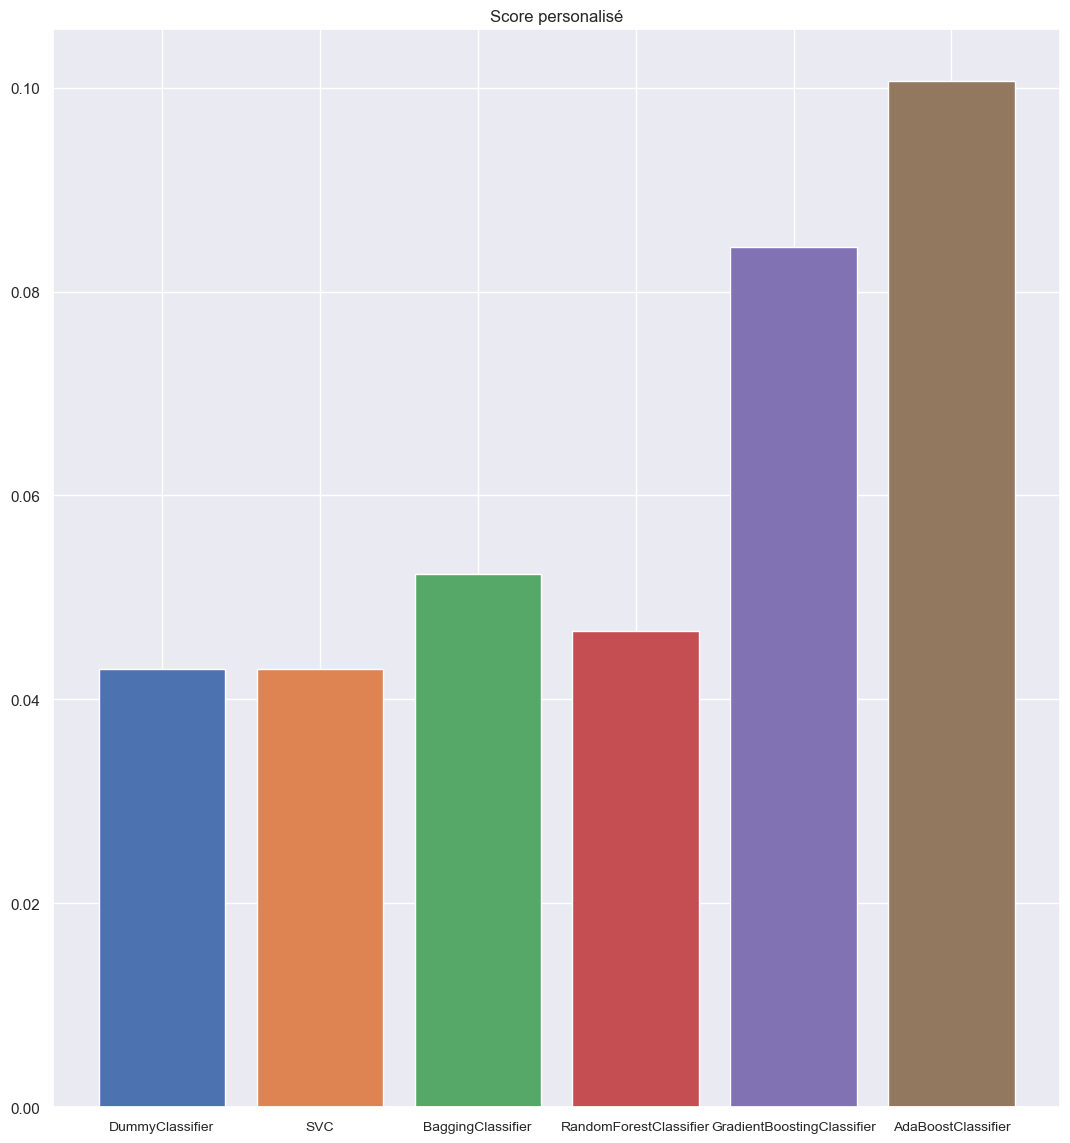

In [64]:
fig, (ax1) = plt.subplots(1, 1, figsize=(13, 14))

DEBUG = True
with timer("DummyClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=dummy.DummyClassifier(strategy='most_frequent'),
                   scoring=custom_scoring,
                   display_importance=False)

with timer("SCV"):
    exec_estimator(ax1=ax1,
                   scaler=preprocessing.StandardScaler(),
                   estimator=svm.SVC(kernel='rbf', random_state= RANDOM_STATE, probability=True),
                   scoring=custom_scoring,
                   display_importance=False)

with timer("BaggingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.BaggingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   scoring=custom_scoring,
                   display_importance=False)
    
with timer("RandomForestClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.RandomForestClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   scoring=custom_scoring,
                   display_importance=False)
    
with timer("GradientBoostingClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.GradientBoostingClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   scoring=custom_scoring,
                   display_importance=False)
    
with timer("AdaBoostClassifier"):
    exec_estimator(ax1=ax1,
                   estimator=ensemble.AdaBoostClassifier(random_state= RANDOM_STATE, n_estimators=100),
                   scoring=custom_scoring,
                   display_importance=False)

del fig, ax1
gc.collect()

Dans le cas de figure d'un scoring personalisé pour lequel les faux positif ont une importance 10 fois plus élévé que les autres cas, on constate, sans optimiser les hyper-paramètres, que AdaBoostClassifier est un modèle qui performe mieux.

- Le process complet pourrait être reïtéré avec ce nouveau scoring
- On pourrait aussi envisager de demander au client quel ratio d'importance au lieu de +1/-10 il souhaiterait donner aux cas de figure pour faire le meilleur choix